### ReneWind

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).

### Data Description


* The data provided is a transformed version of original data which was collected using sensors.


* Train.csv - To be used for training and tuning of models.

* Test.csv - To be used only for testing the performance of the final best model.



* Both the datasets consist of 40 predictor variables and 1 target variable









### Objective


“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 40000 observations in the training set and 10000 in the test set.

The objective is to build various classification models, tune them and find the best one that will help identify failures so that the generator could be repaired before failing/breaking and the overall maintenance cost of the generators can be brought down.

“1” in the target variables should be considered as “failure” and “0” will represent “No failure”.

The nature of predictions made by the classification model will translate as follows:

True positives (TP) are failures correctly predicted by the model.
False negatives (FN) are real failures in a wind turbine where there is no detection by model.
False positives (FP) are detections in a wind turbine where there is no failure.
So, the maintenance cost associated with the model would be:

Maintenance cost = TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost) where,

Replacement cost = $40,000
Repair cost = $15,000
Inspection cost = $5,000
Here the objective is to reduce the maintenance cost so, we want a metric that could reduce the maintenance cost.

The minimum possible maintenance cost = Actual failures*(Repair cost) = (TP + FN)*(Repair cost)
The maintenance cost associated with model = TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)
So, we will try to maximize the ratio of minimum possible maintenance cost and the maintenance cost associated with the model.

The value of this ratio will lie between 0 and 1, the ratio will be 1 only when the maintenance cost associated with the model will be equal to the minimum possible maintenance cost.

In [ ]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('Train.csv') ##  read the data
df_test = pd.read_csv('Test.csv') ##  read the data

In [ ]:
# Checking the number of rows and columns in the training data
df.shape ##   view dimensions of the train data


(40000, 41)

In [ ]:

# Checking the number of rows and columns in the test data
df_test.shape ## view dimensions of the test data

(10000, 41)

### Data OverView

In [ ]:
# let's create a copy of the training data
data = df.copy()

In [ ]:
# let's create a copy of the training data
data_test = df_test.copy()

In [ ]:
# let's view the first 5 rows of the data
data.head() ## view top 5 rows of the data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,-2.910,-2.569,4.109,1.317,-1.621,-3.827,-1.617,0.669,0.387,0.854,-6.353,4.272,3.162,0.258,-3.547,-4.285,2.897,1.508,3.668,7.124,-4.096,1.015,-0.970,-0.968,2.064,-1.646,0.427,0.735,-4.470,-2.772,-2.505,-3.783,-6.823,4.909,0.482,5.338,2.381,-3.128,3.527,-3.020,0
2,4.284,5.105,6.092,2.640,-1.041,1.308,-1.876,-9.582,3.470,0.763,-2.573,-3.350,-0.595,-5.247,-4.310,-16.232,-1.000,2.318,5.942,-3.858,-11.599,4.021,-6.281,4.633,0.930,6.280,0.851,0.269,-2.206,-1.329,-2.399,-3.098,2.690,-1.643,7.566,-3.198,-3.496,8.105,0.562,-4.227,0
3,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
4,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0


In [ ]:
# let's view the last 5 rows of the data
data.tail() ##  view last 5 rows of the data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
39995,-3.897,-3.942,-0.351,-2.417,1.108,-1.528,-3.520,2.055,-0.234,-0.358,-3.782,2.180,6.112,1.985,-8.330,-1.639,-0.915,5.672,-3.924,2.133,-4.502,2.777,5.728,1.620,-1.700,-0.042,-2.923,-2.760,-2.254,2.552,0.982,7.112,1.476,-3.954,1.856,5.029,2.083,-6.409,1.477,-0.874,0
39996,-3.187,-10.052,5.696,-4.370,-5.355,-1.873,-3.947,0.679,-2.389,5.457,1.583,3.571,9.227,2.554,-7.039,-0.994,-9.665,1.155,3.877,3.524,-7.015,-0.132,-3.446,-4.801,-0.876,-3.812,5.422,-3.732,0.609,5.256,1.915,0.403,3.164,3.752,8.530,8.451,0.204,-7.130,4.249,-6.112,0
39997,-2.687,1.961,6.137,2.600,2.657,-4.291,-2.344,0.974,-1.027,0.497,-9.589,3.177,1.055,-1.416,-4.669,-5.405,3.720,2.893,2.329,1.458,-6.429,1.818,0.806,7.786,0.331,5.257,-4.867,-0.819,-5.667,-2.861,4.674,6.621,-1.989,-1.349,3.952,5.450,-0.455,-2.202,1.678,-1.974,0
39998,0.521,0.096,8.457,2.138,-1.636,-2.713,-2.693,-3.410,1.936,2.012,-4.989,-0.819,4.166,-1.192,-5.033,-8.523,-1.950,0.017,4.505,2.031,-8.849,0.566,-6.040,-0.043,1.656,4.250,1.727,-1.686,-3.963,-2.642,1.939,-1.257,-1.136,1.434,5.905,3.752,-1.867,-1.918,2.573,-5.019,0
39999,2.403,-1.336,6.451,-5.356,-0.434,0.255,-1.120,-2.523,-0.654,2.316,-2.862,0.199,1.593,-0.337,-0.709,-4.408,-3.683,2.973,-1.223,-1.958,-4.454,0.464,-4.952,-1.624,2.965,2.009,5.712,-2.910,-2.287,-3.676,5.678,-4.310,-0.709,-1.359,1.639,7.766,-0.245,-1.124,2.872,1.902,0


In [ ]:
# let's check the data types of the columns in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      39954 non-null  float64
 1   V2      39961 non-null  float64
 2   V3      40000 non-null  float64
 3   V4      40000 non-null  float64
 4   V5      40000 non-null  float64
 5   V6      40000 non-null  float64
 6   V7      40000 non-null  float64
 7   V8      40000 non-null  float64
 8   V9      40000 non-null  float64
 9   V10     40000 non-null  float64
 10  V11     40000 non-null  float64
 11  V12     40000 non-null  float64
 12  V13     40000 non-null  float64
 13  V14     40000 non-null  float64
 14  V15     40000 non-null  float64
 15  V16     40000 non-null  float64
 16  V17     40000 non-null  float64
 17  V18     40000 non-null  float64
 18  V19     40000 non-null  float64
 19  V20     40000 non-null  float64
 20  V21     40000 non-null  float64
 21  V22     40000 non-null  float64
 22

In [ ]:
# let's check for duplicate values in the data
data.duplicated().sum() ##  check dulicate entries in the data

0

In [ ]:
# let's check for missing values in the data
data.isnull().sum() ##  check missing entries in the train data

V1        46
V2        39
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

In [ ]:
# let's check for missing values in the data
data_test.isnull().sum() ##   check missing entries in the test data

V1        11
V2         7
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

In [ ]:
# let's view the statistical summary of the numerical columns in the data
data.describe().T ## print the statitical summary of the train data

,count,mean,std,min,25%,50%,75%,max
V1,39954.000,-0.288,3.449,-13.502,-2.751,-0.774,1.837,17.437
V2,39961.000,0.443,3.139,-13.212,-1.638,0.464,2.538,13.089
V3,40000.000,2.506,3.406,-11.469,0.203,2.265,4.585,18.366
V4,40000.000,-0.066,3.437,-16.015,-2.350,-0.124,2.149,13.280
V5,40000.000,-0.045,2.107,-8.613,-1.507,-0.097,1.346,9.403
V6,40000.000,-1.001,2.037,-10.227,-2.363,-1.007,0.374,7.065
V7,40000.000,-0.893,1.757,-8.206,-2.037,-0.935,0.207,8.006
V8,40000.000,-0.563,3.299,-15.658,-2.660,-0.384,1.714,11.679
V9,40000.000,-0.008,2.162,-8.596,-1.494,-0.052,1.426,8.507
V10,40000.000,-0.002,2.183,-11.001,-1.391,0.106,1.486,8.108


### EDA

## Plotting histograms and boxplots for all the variables


In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

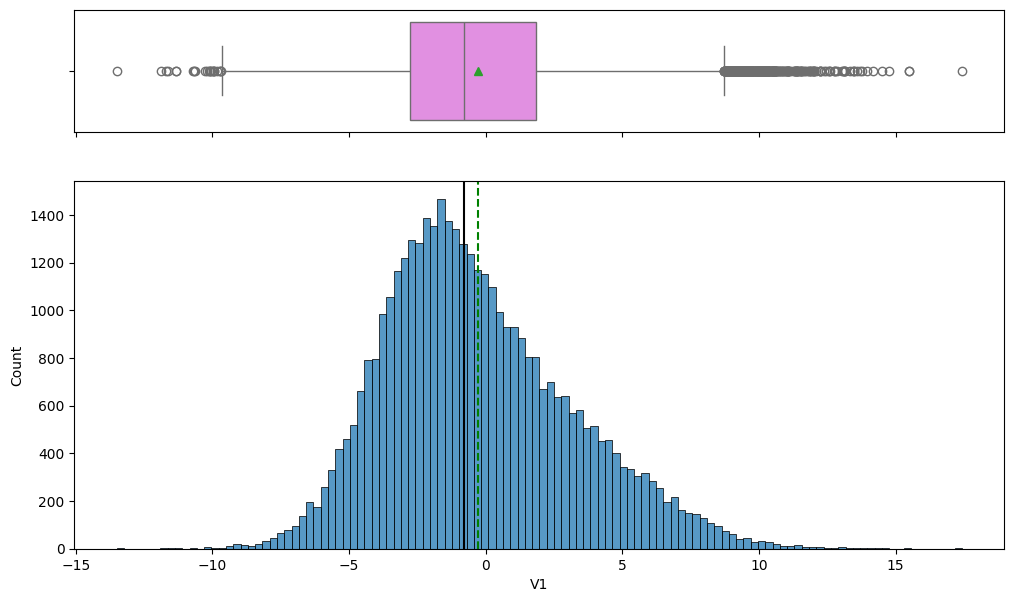

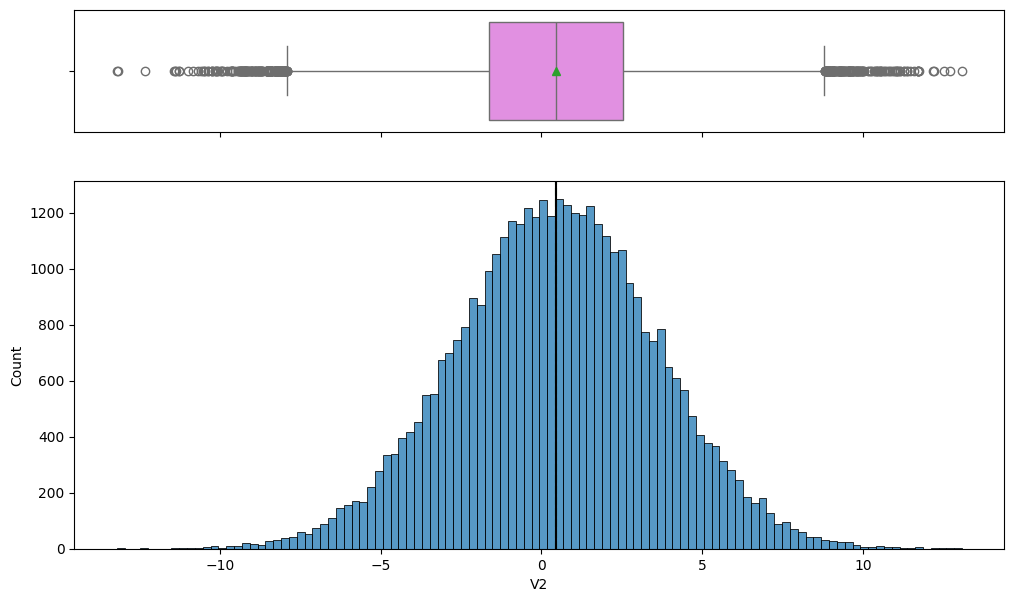

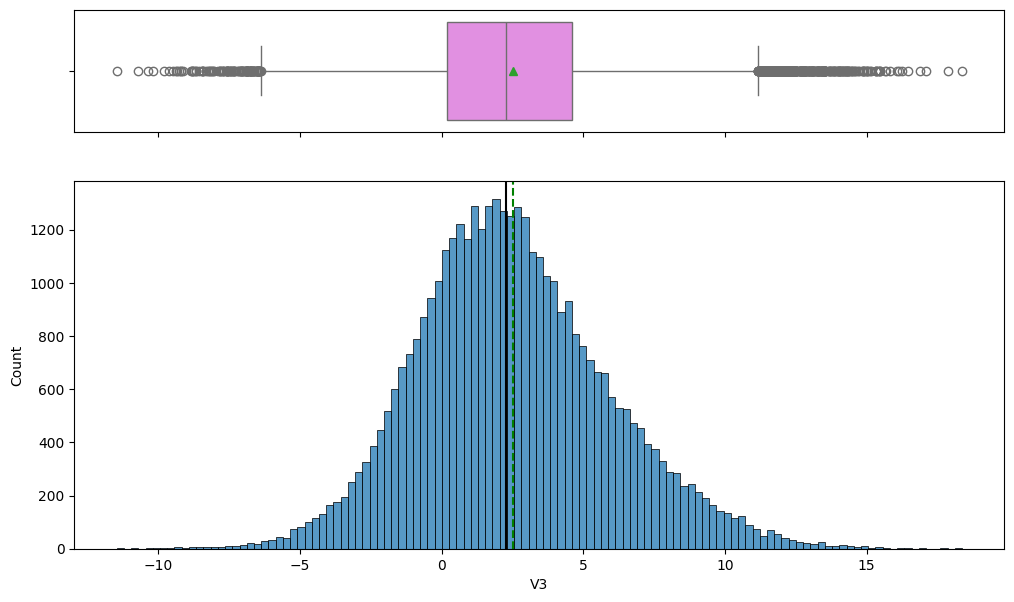

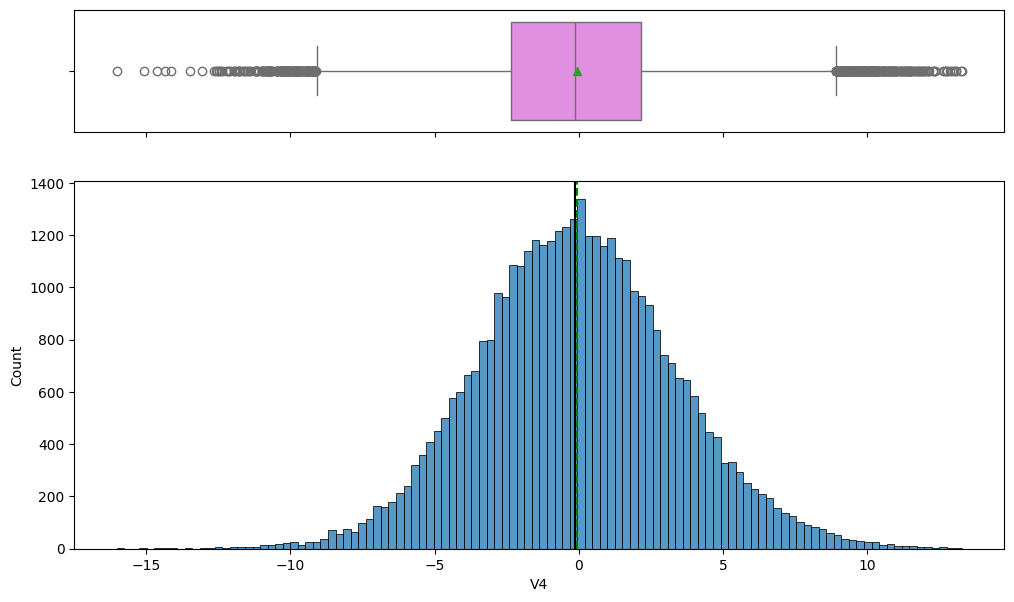

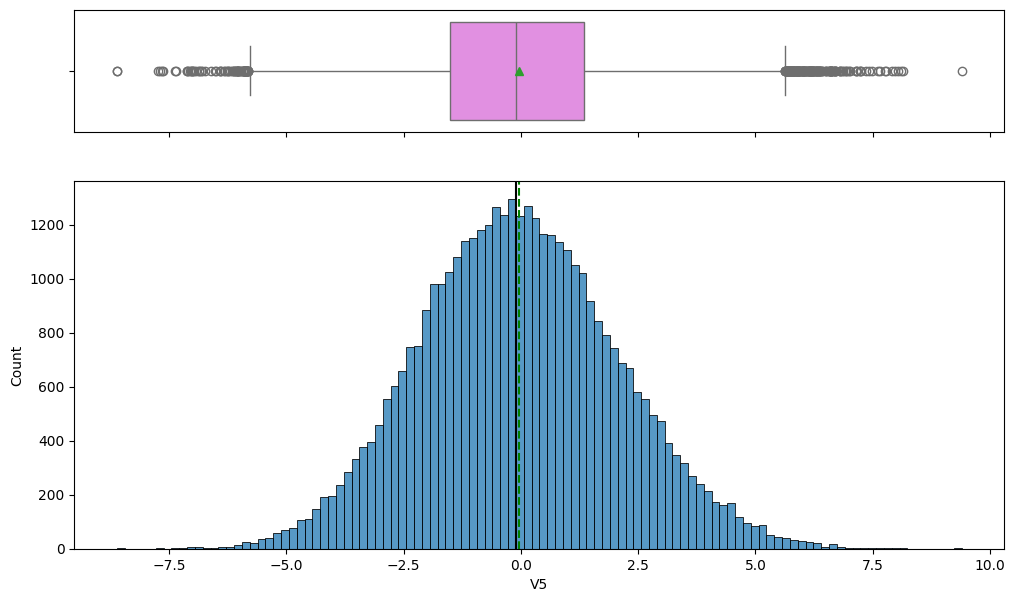

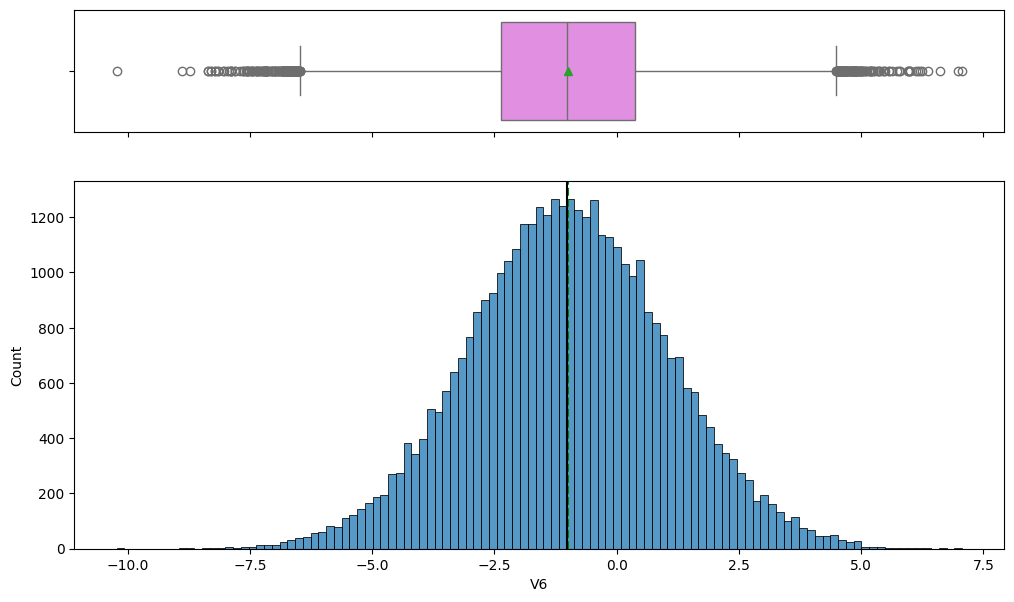

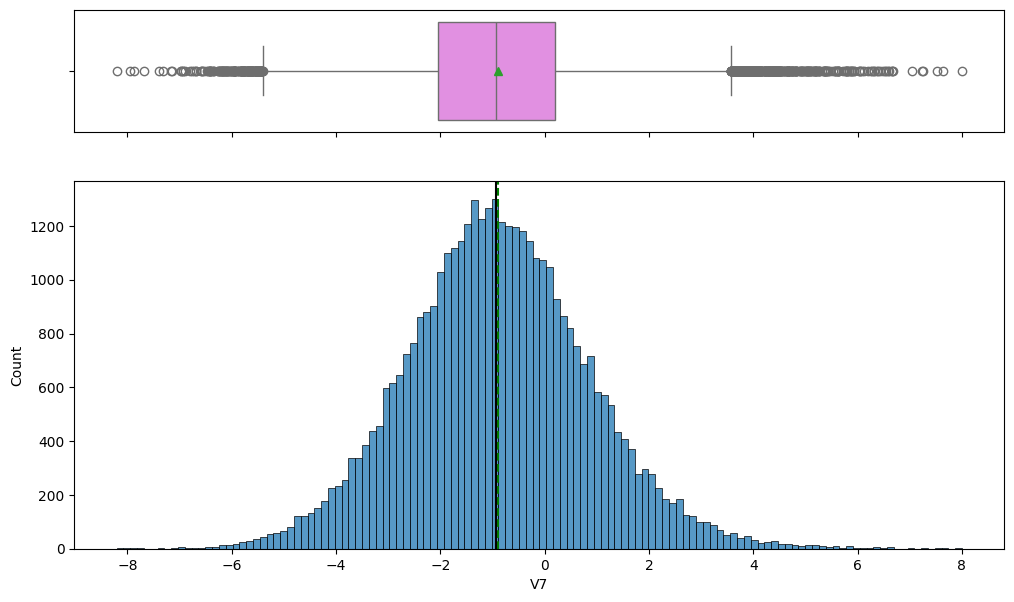

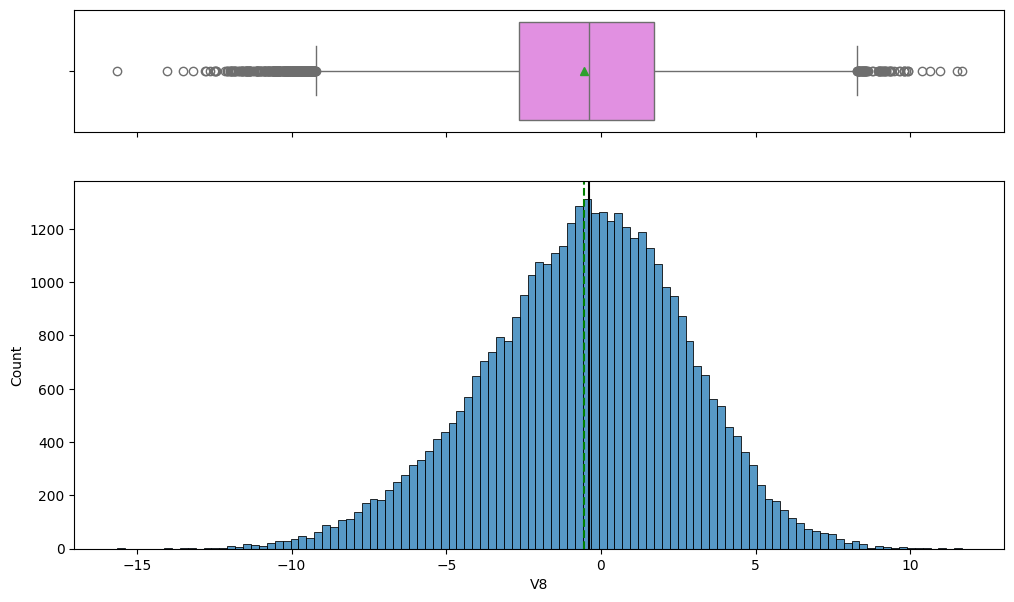

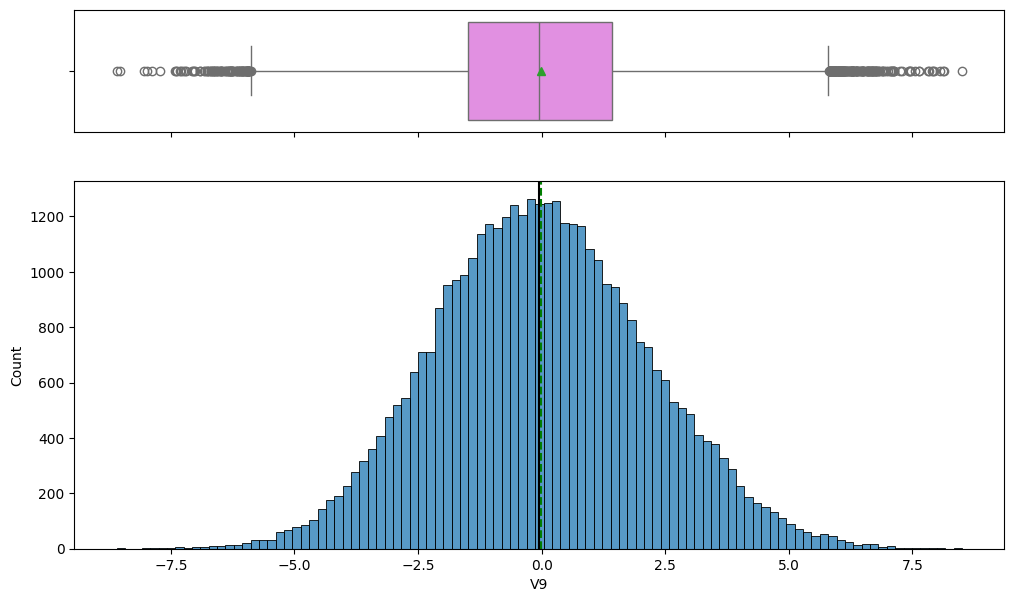

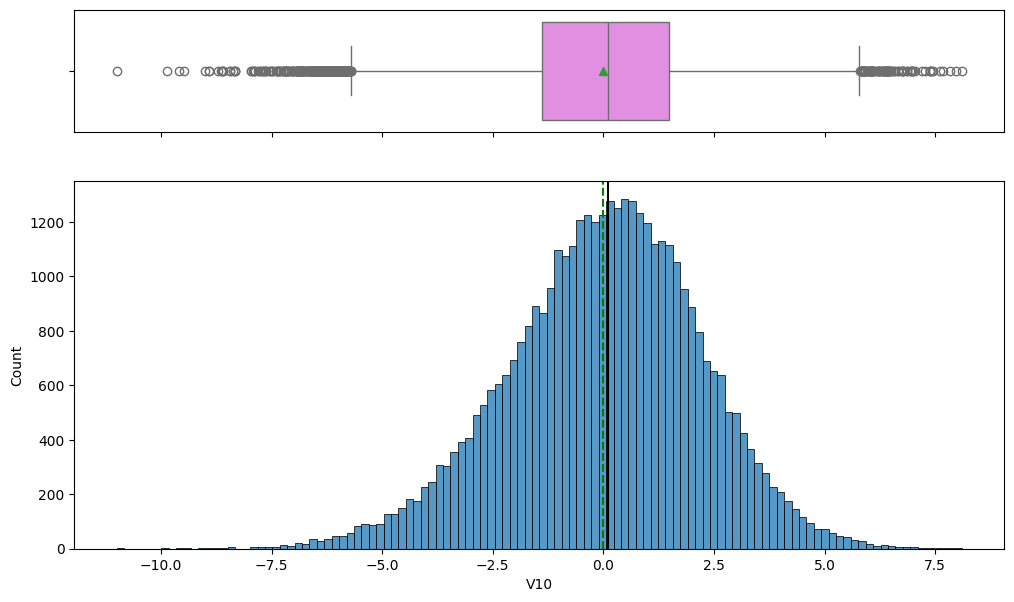

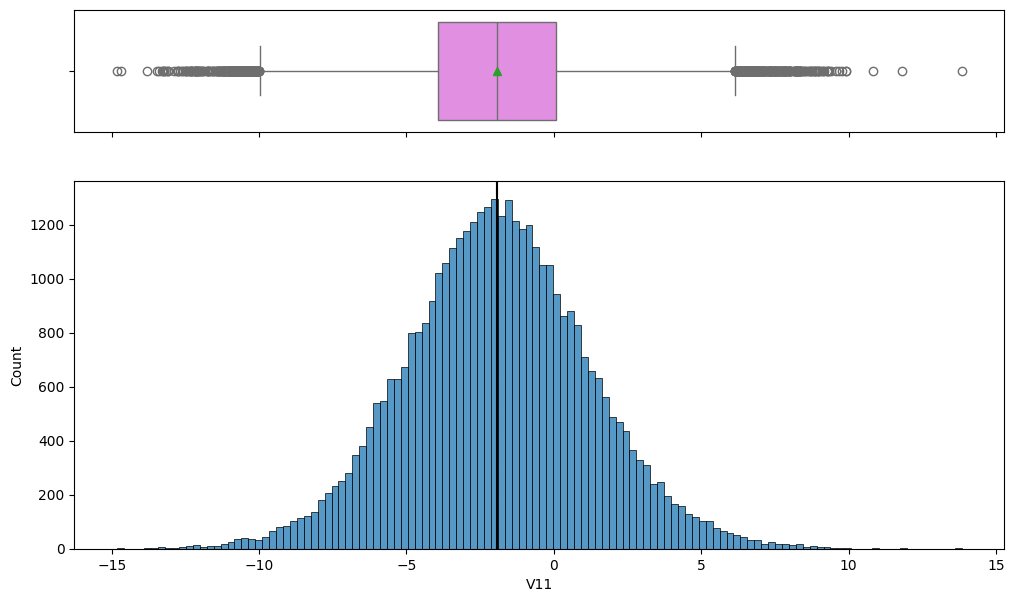

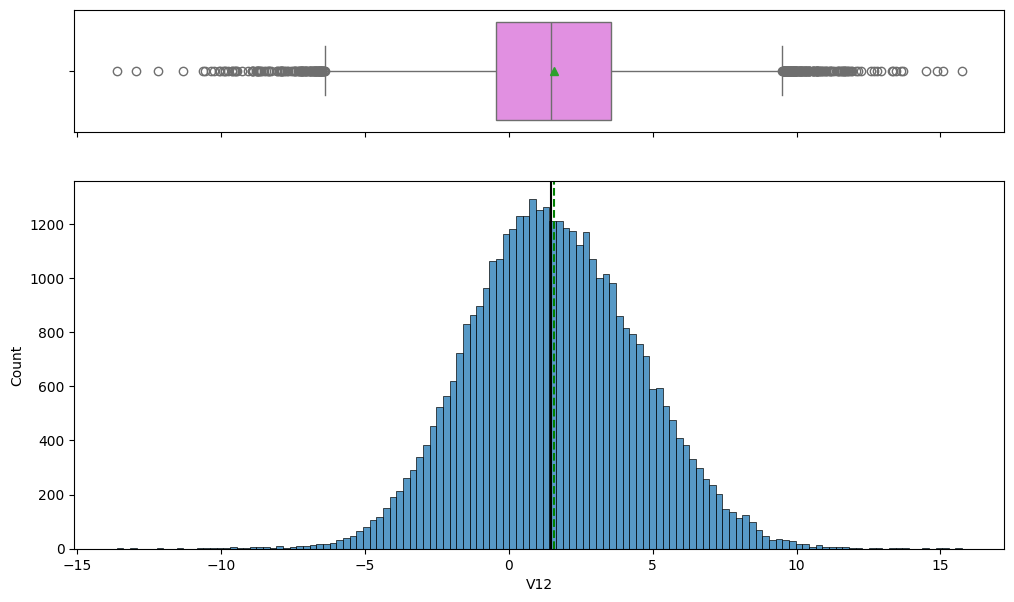

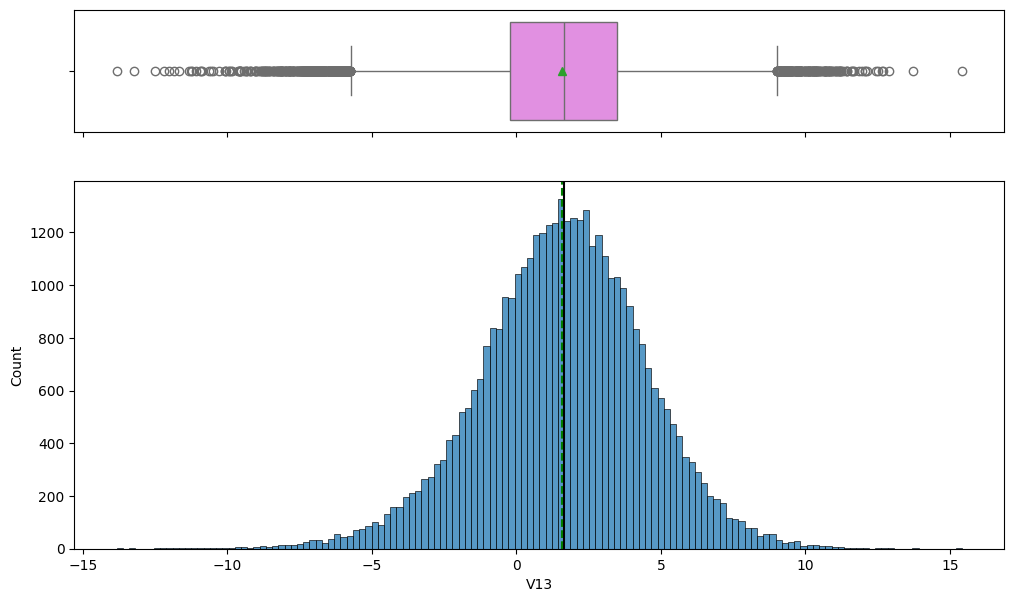

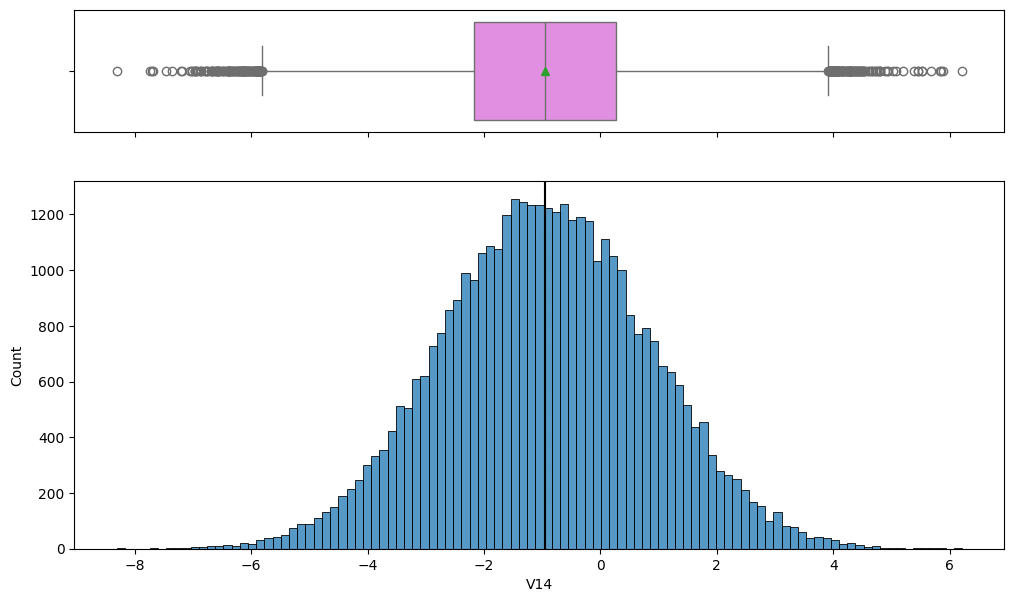

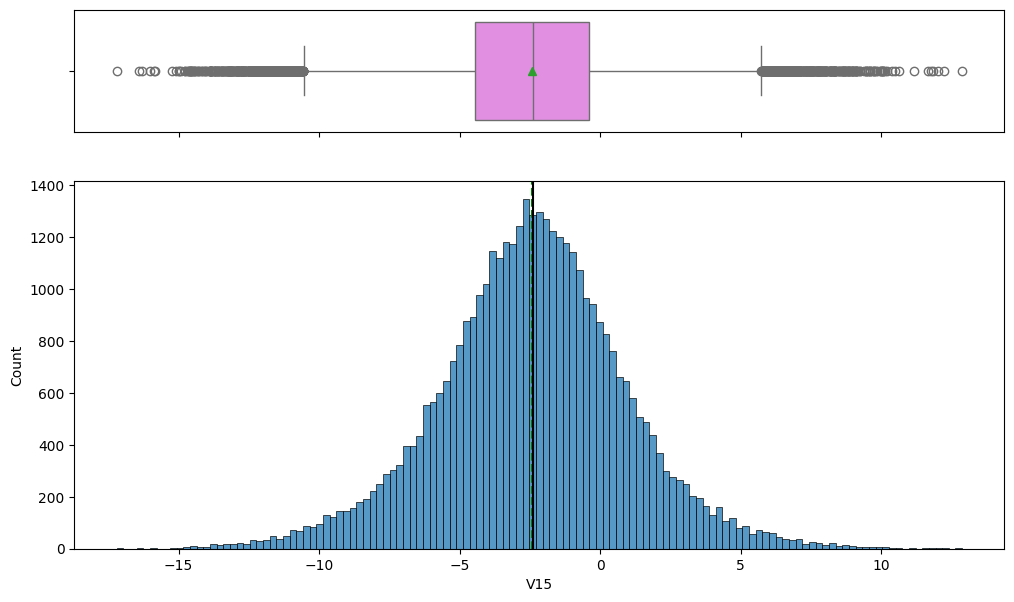

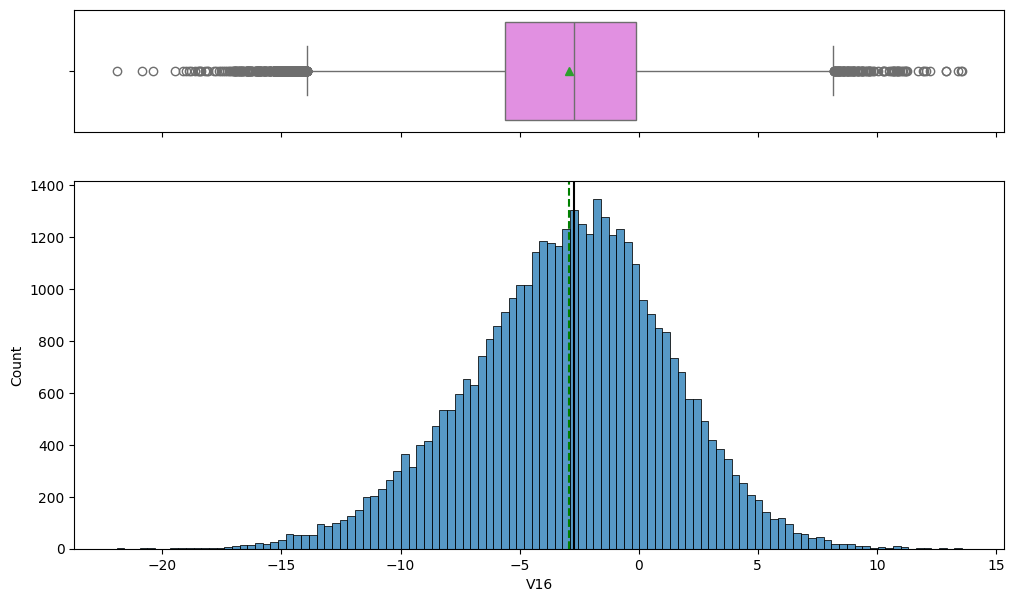

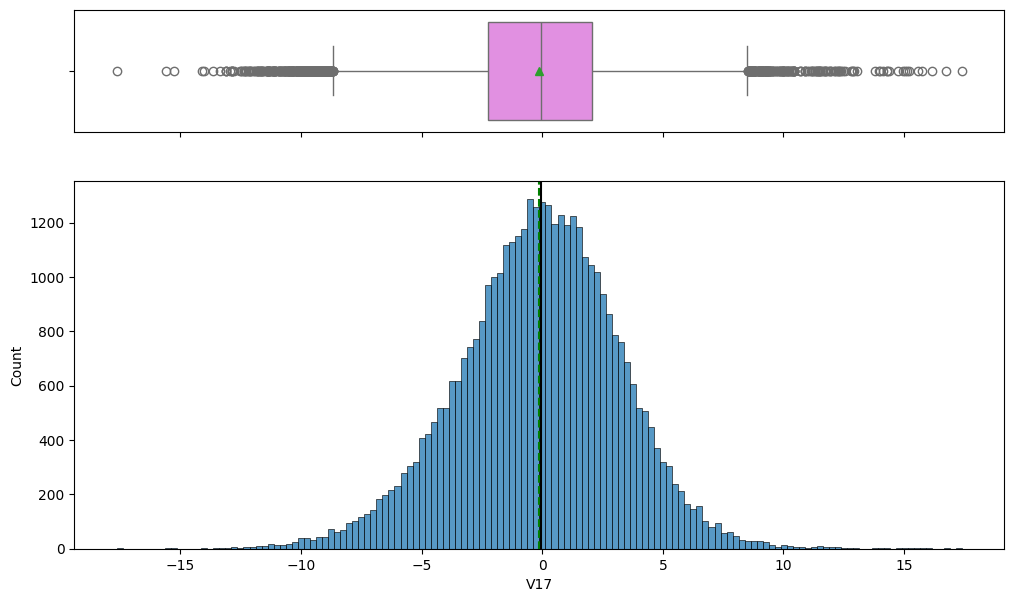

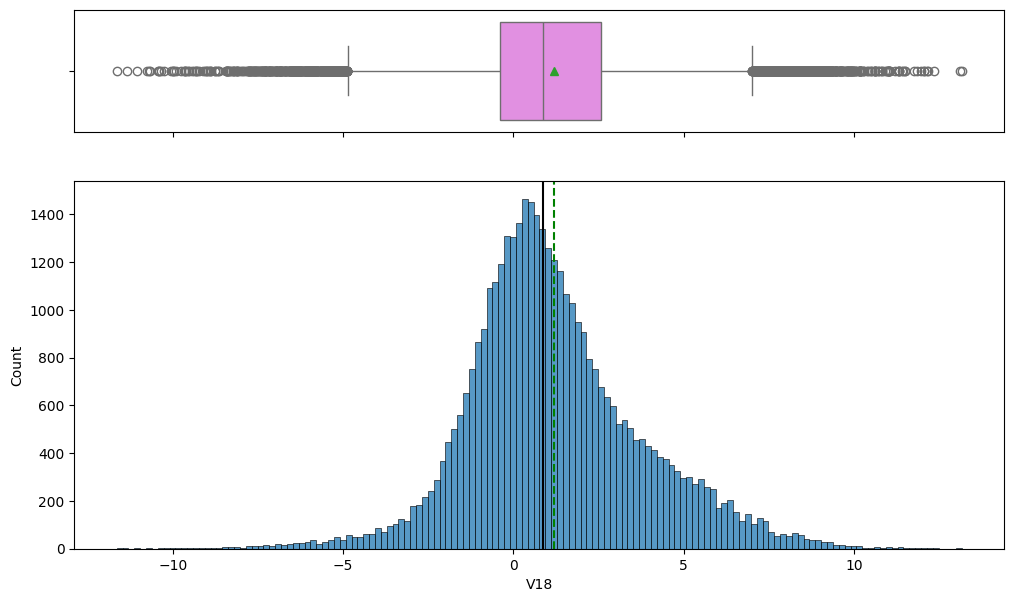

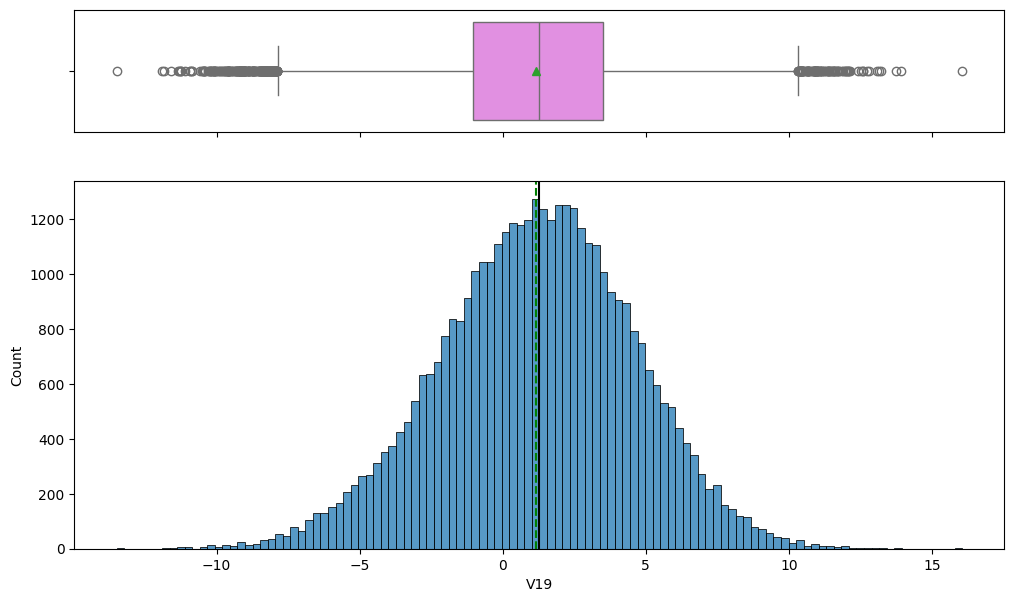

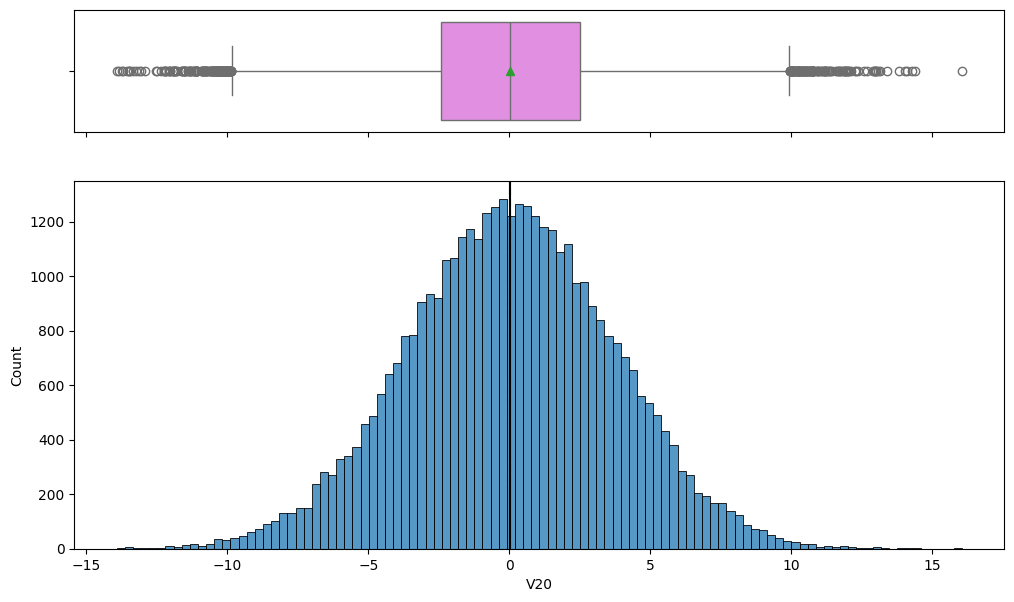

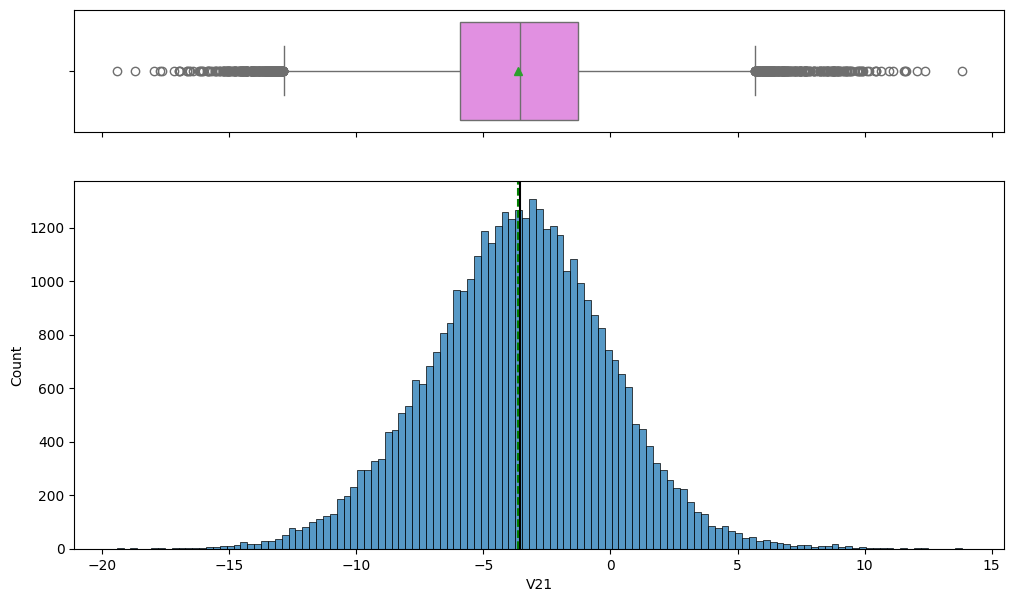

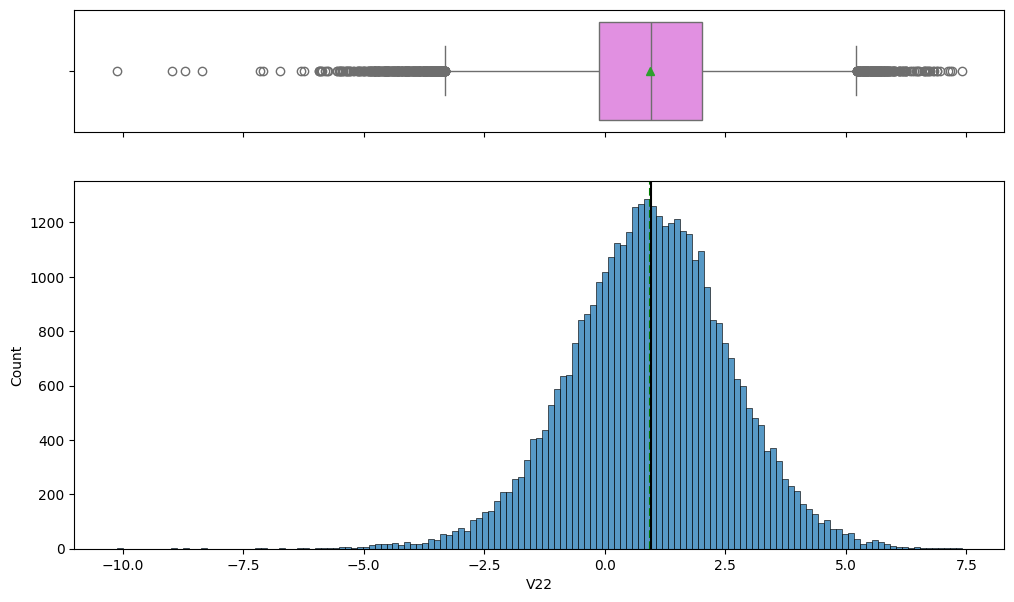

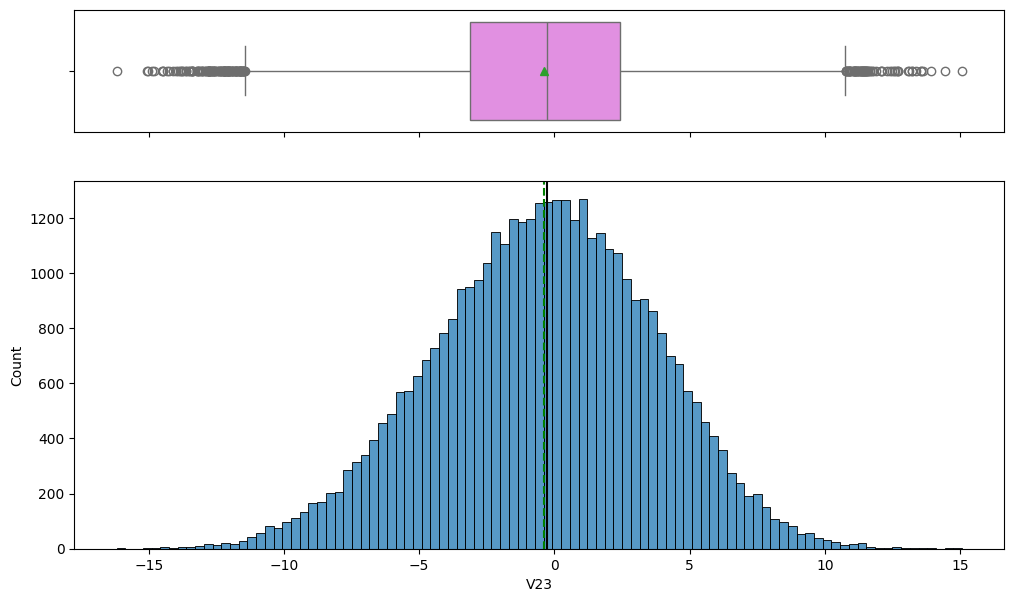

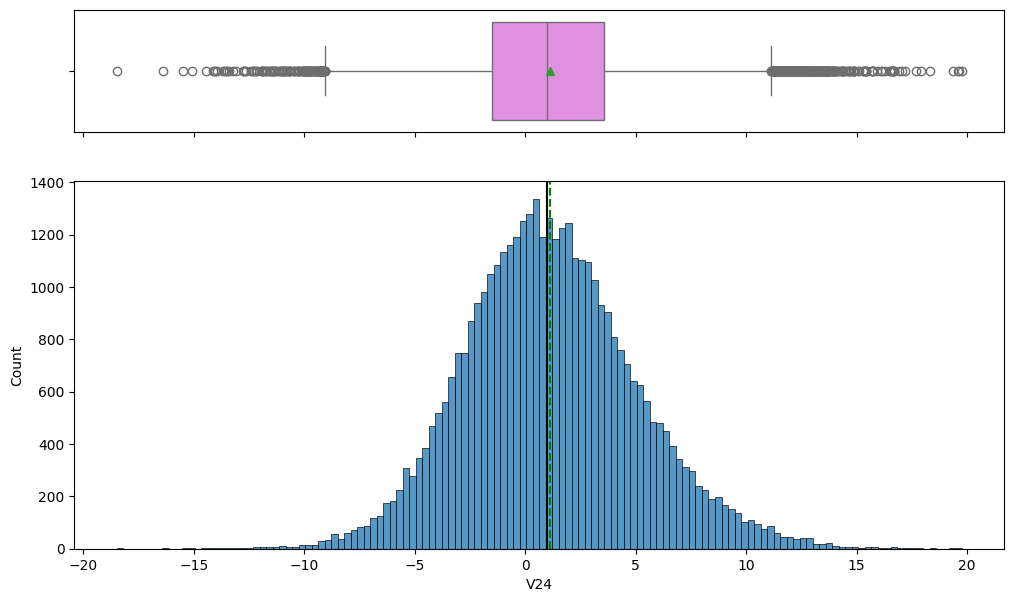

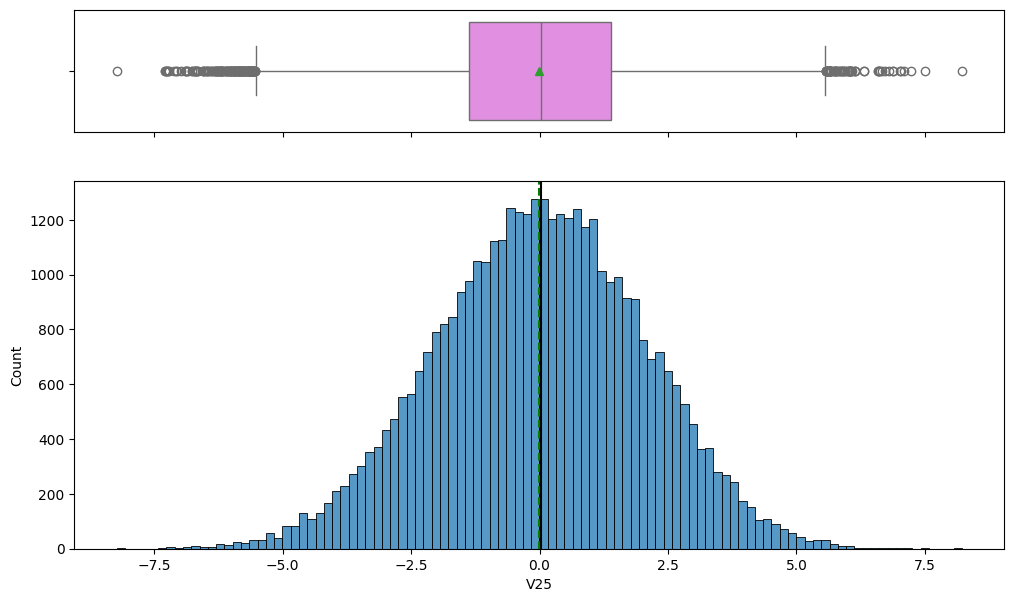

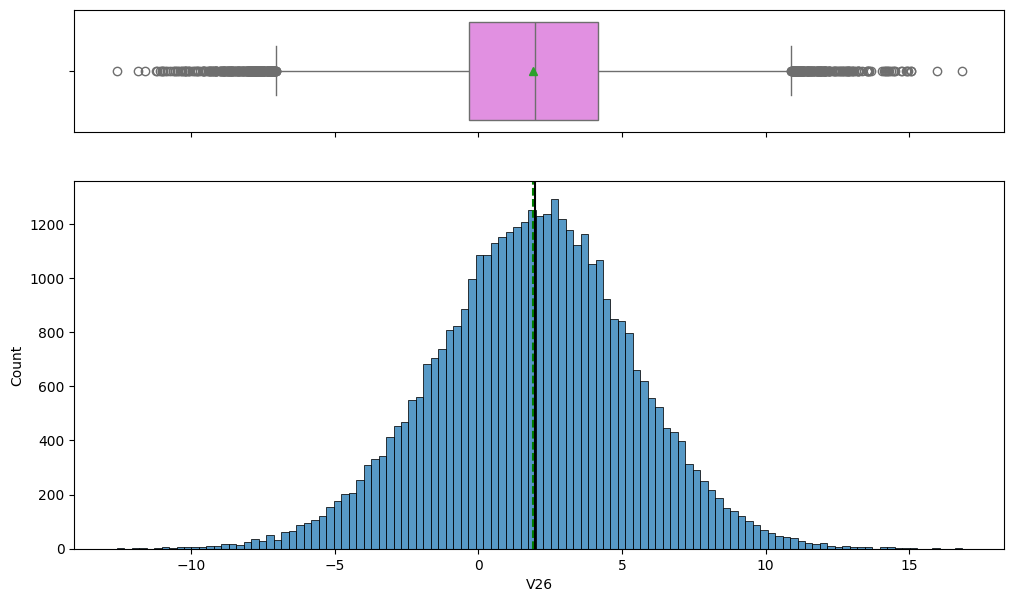

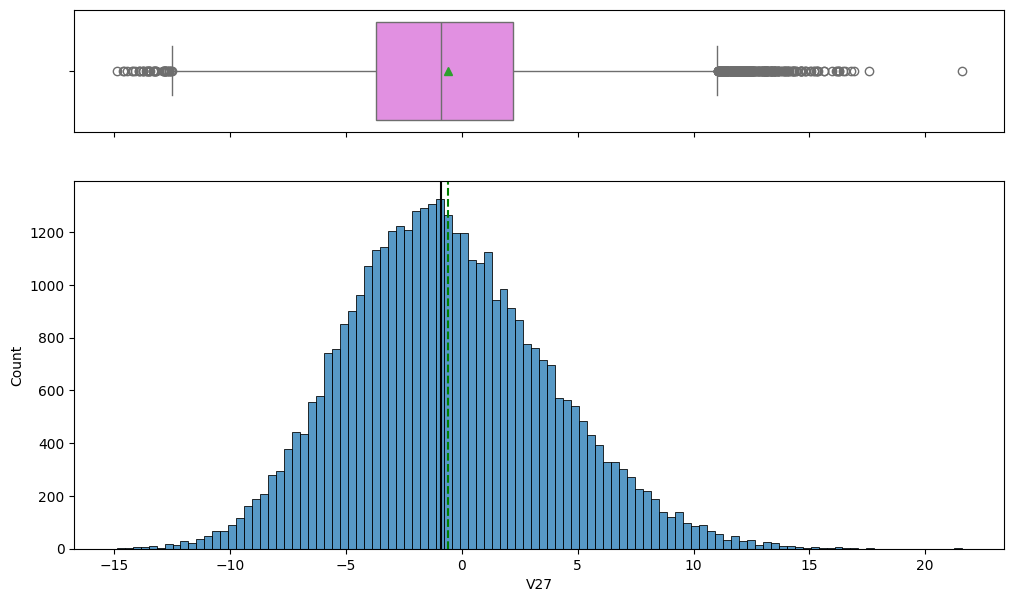

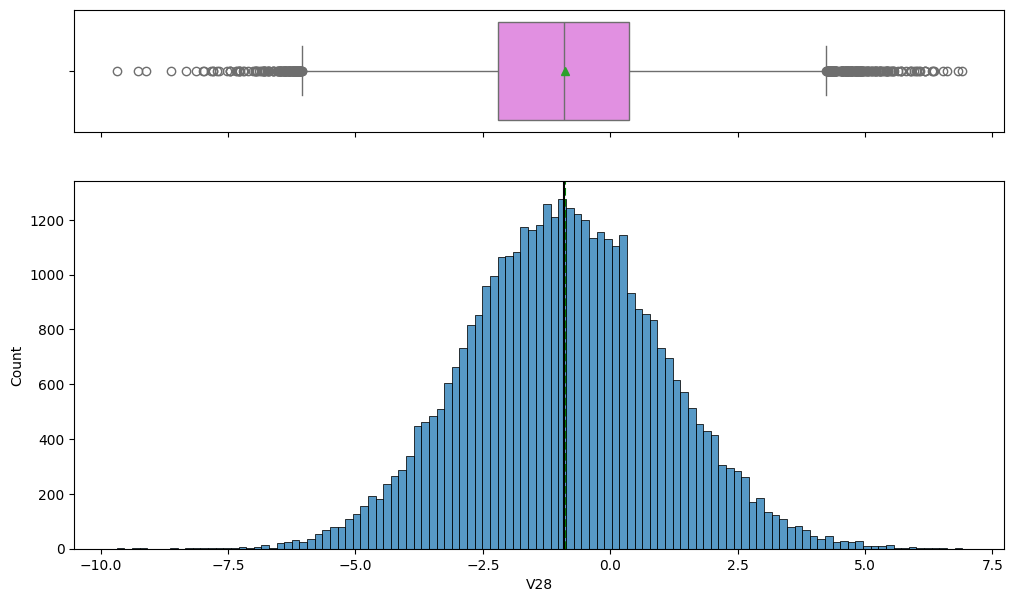

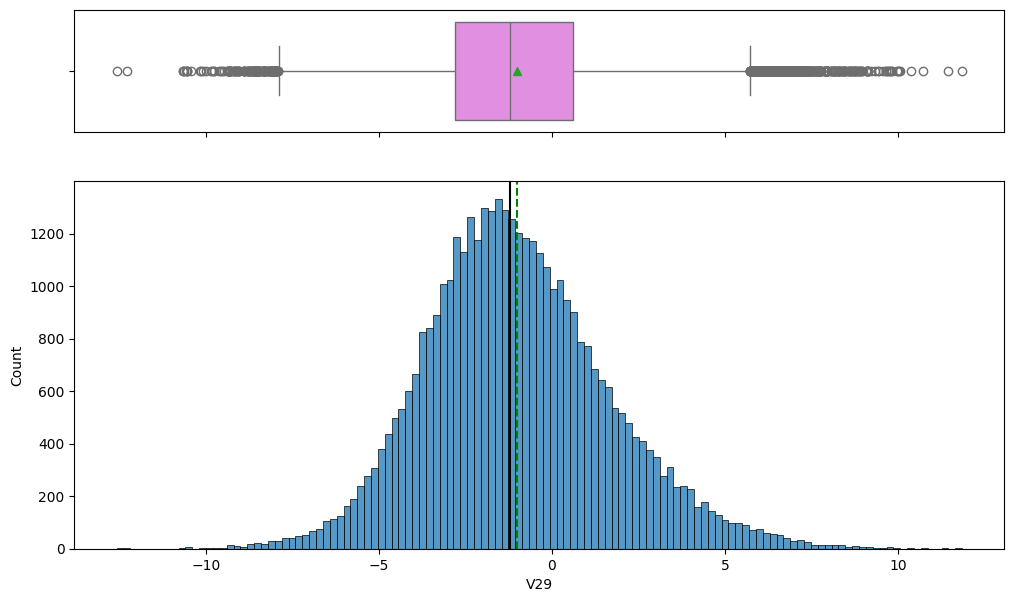

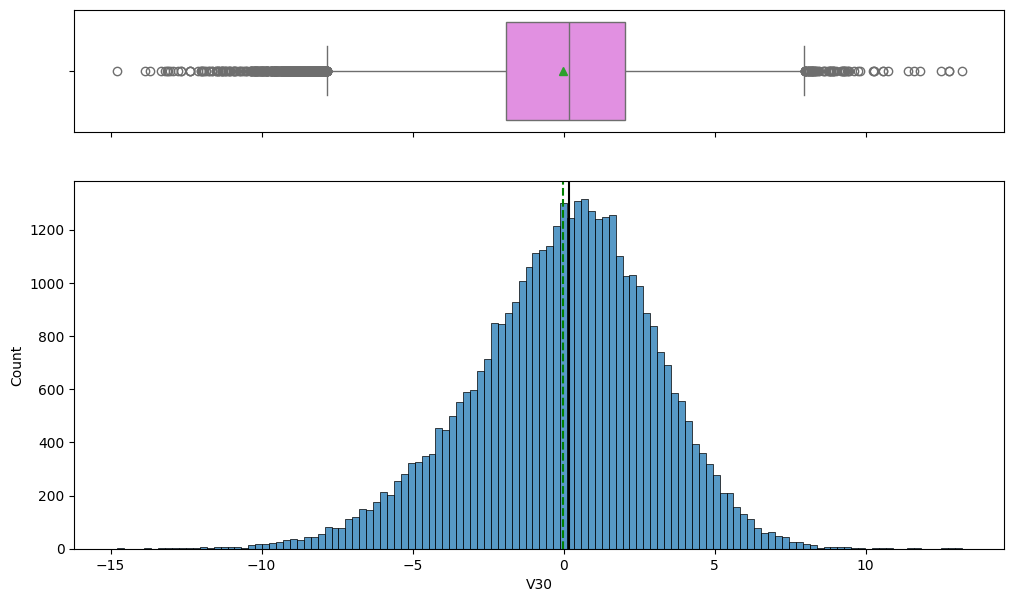

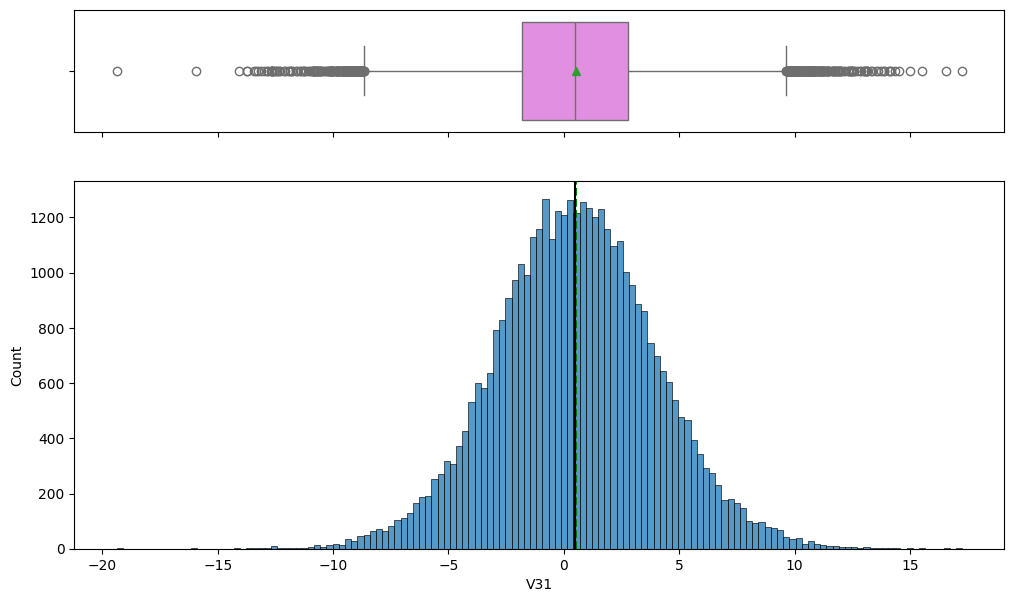

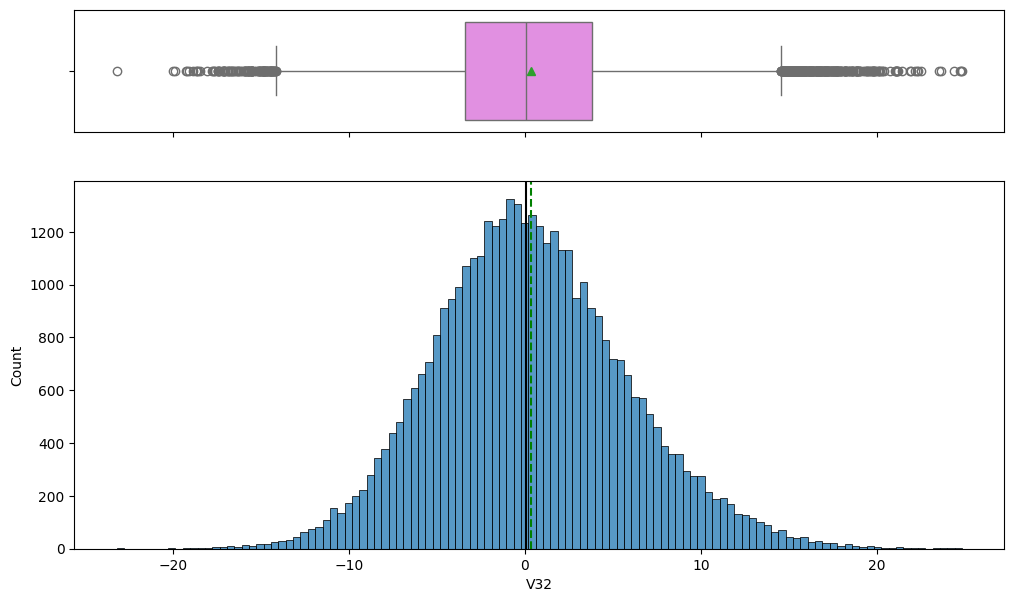

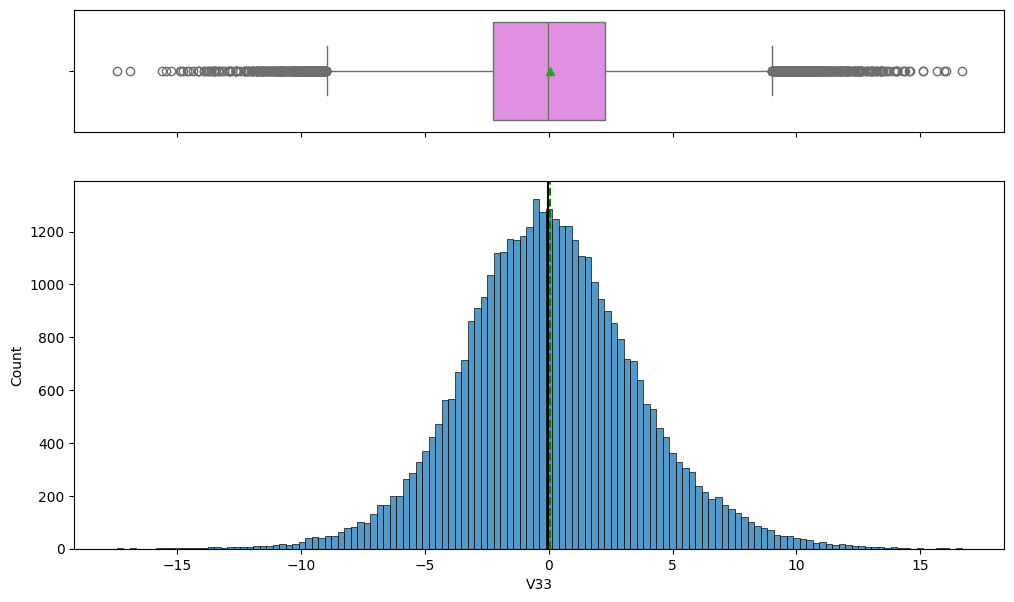

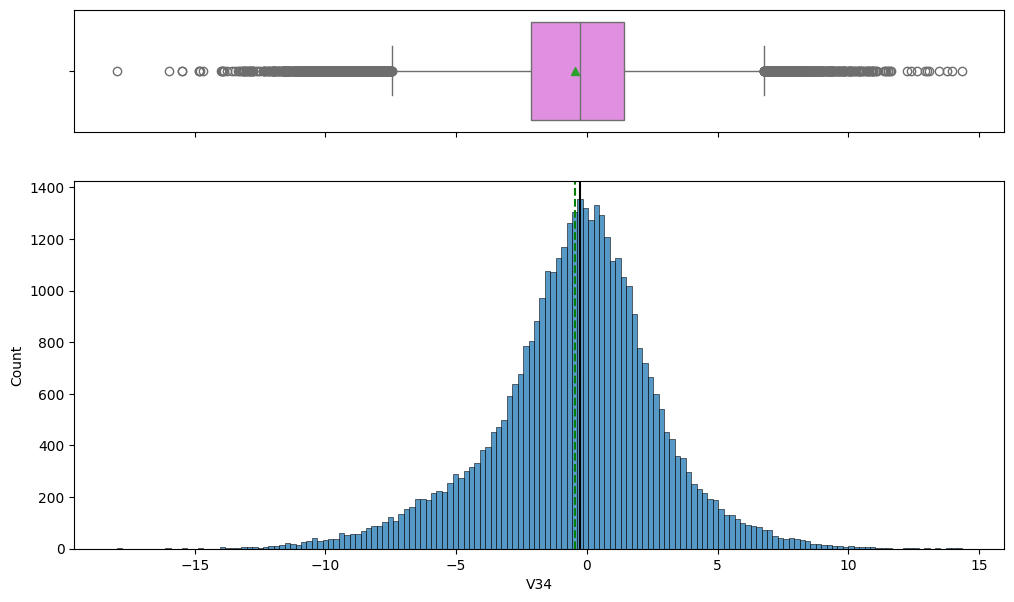

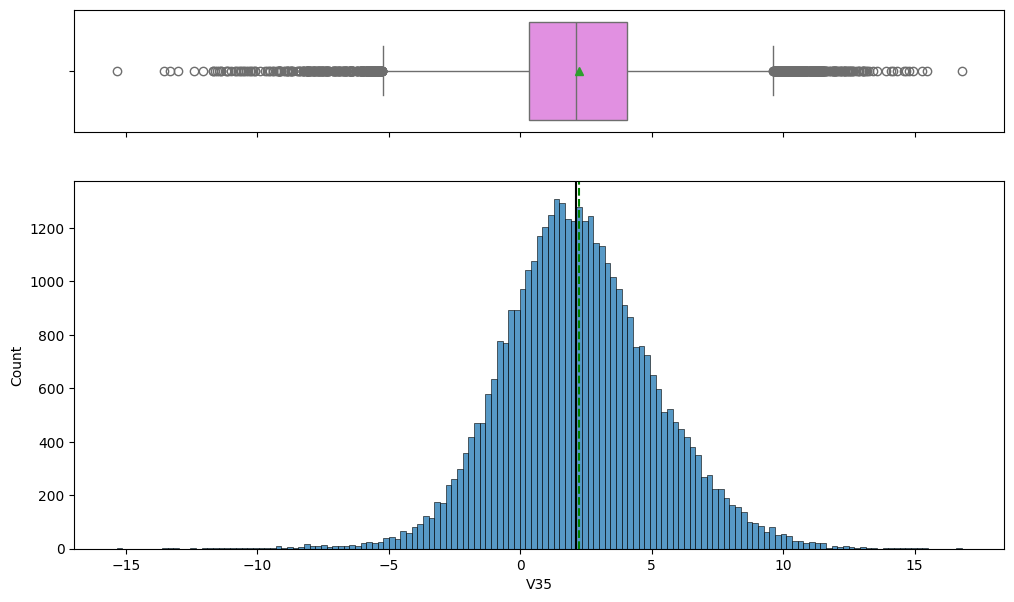

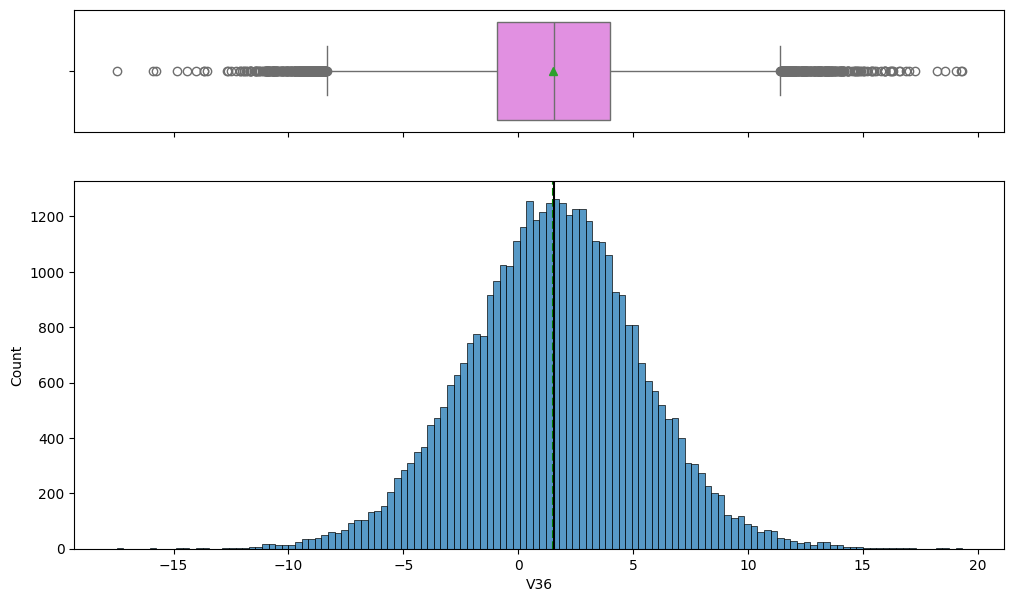

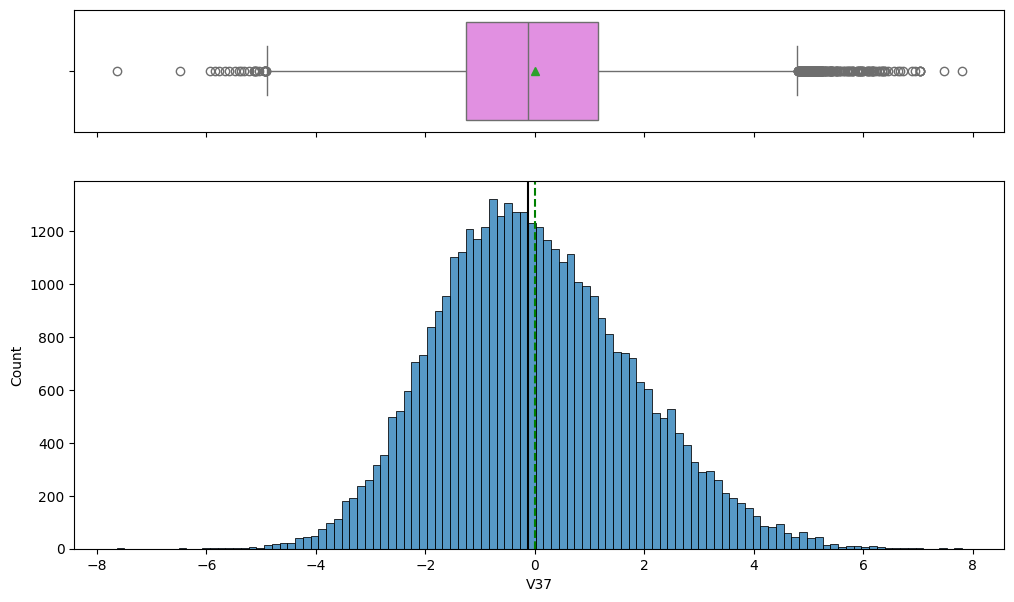

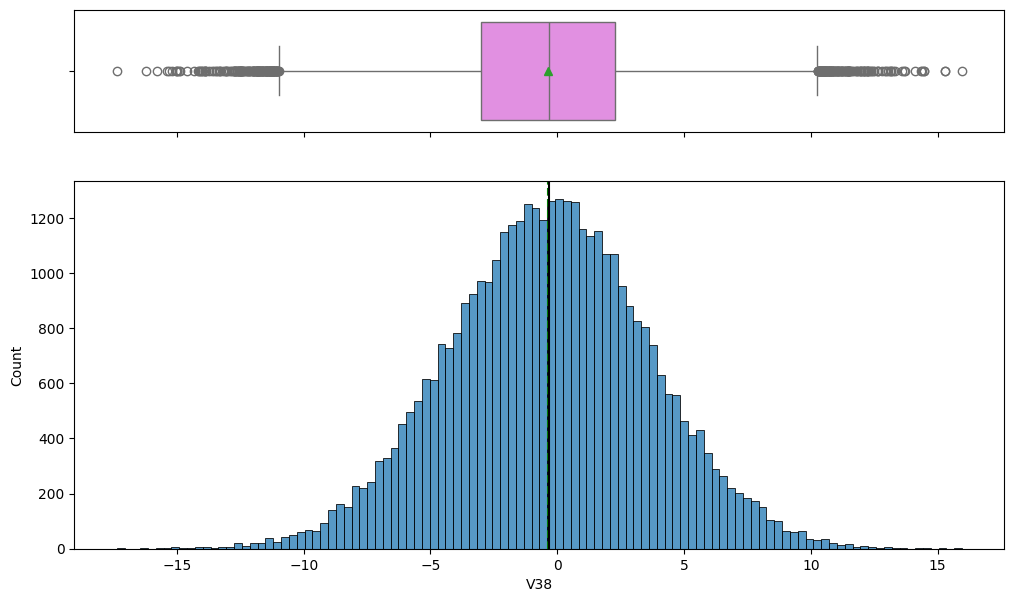

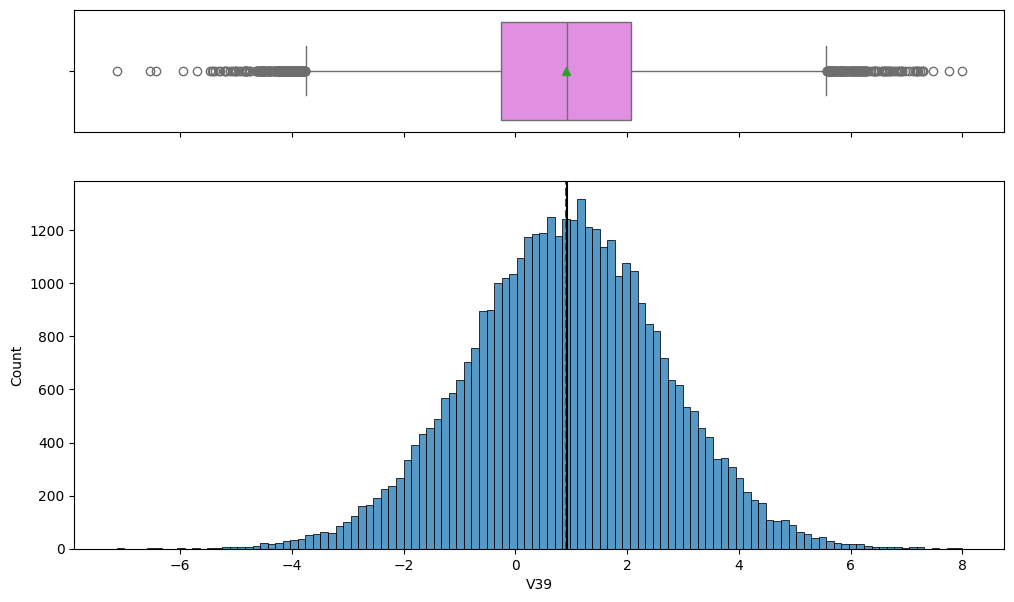

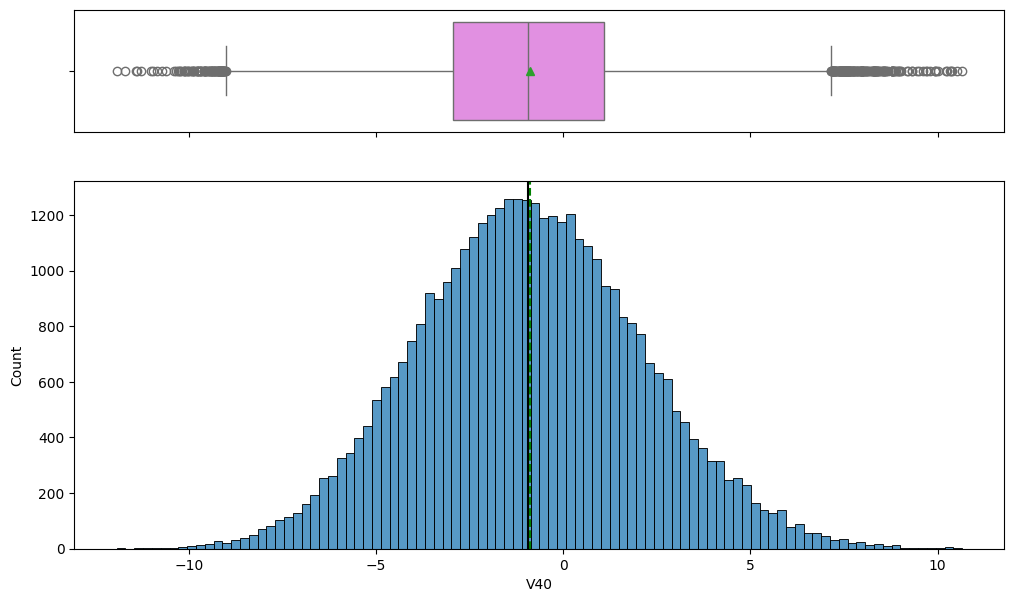

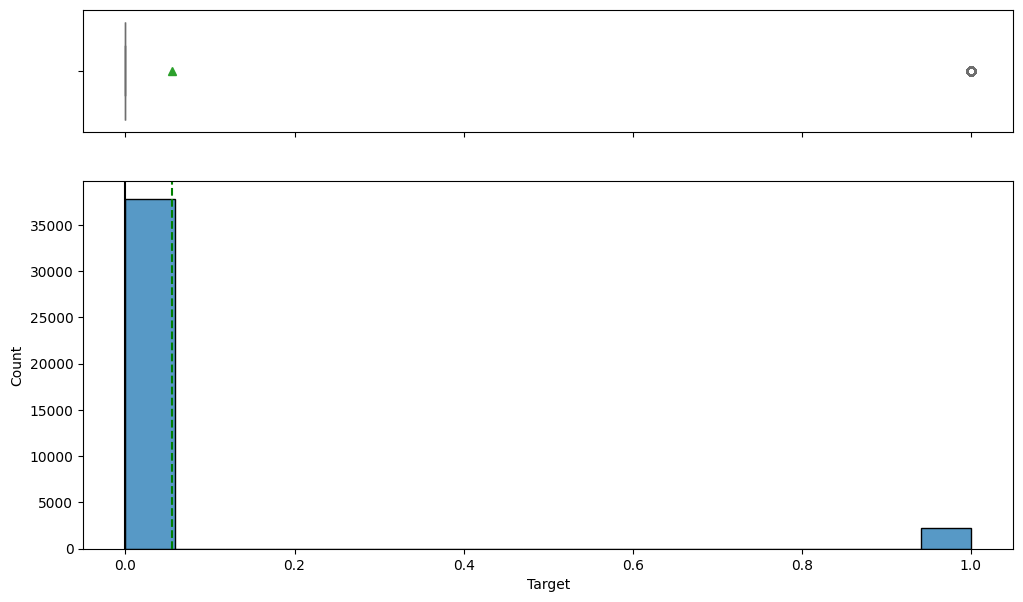

In [ ]:
#for plotting all histograms in one go
for feature in df.columns:
    histogram_boxplot(df, feature, figsize=(12, 7), kde=False, bins=None)


Observations:

Most of the predictor variables appear to have a normal to approximately normal distribution
There appears to be a number of outliers on both the left and right for all predictor variables

# Function to plot labeled bar plots for the Target variable


In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot
        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot


In [ ]:
# Show class distribution in target variable in training data

df['Target'].value_counts()

Target
0    37813
1     2187
Name: count, dtype: int64

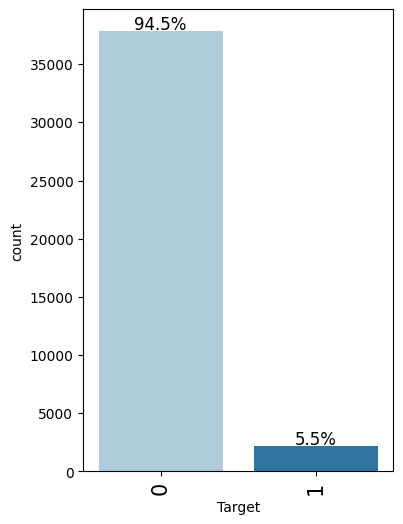

In [ ]:
# Show class distribution in target variable in training data visually

labeled_barplot(df, "Target", perc=True)

In [ ]:
df_test['Target'].value_counts()

Target
0    9453
1     547
Name: count, dtype: int64

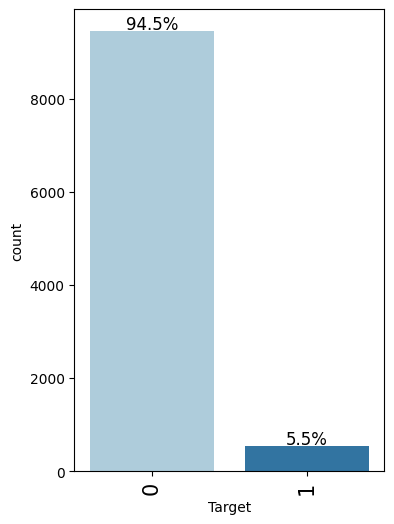

In [ ]:
# Show class distribution in target variable in Test data visually

labeled_barplot(df_test, "Target", perc=True)

### Data PreProcessing

In [ ]:
#Separating target variable from predictor variables in training data

# Separating target variable from predictor variables in training data
X=df.drop(['Target'],axis=1)
y=df['Target']

In [ ]:
# Separating target variable from predictor variables in test data
X_test=df_test.drop(['Target'],axis=1)
y_test=df_test['Target']

In [ ]:
#Split Train dataset into training and validation set

#Splitting training dataset into train and validation sets (75:25)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)

In [ ]:
# Display training, validation and test data shapes
print(X_train.shape, X_val.shape, X_test.shape)

(30000, 40) (10000, 40) (10000, 40)


Missing Value treatment

In [ ]:
# Create an instance of Simple-Imputer
imputer = SimpleImputer(strategy="median")

In [ ]:
# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
X_val =  pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

# Transform the test data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [ ]:
# Checking that no column has missing values in train, validation or test sets
print("Training Data")
print(X_train.isna().sum())
print("-" * 200)

print("Validation Data")
print(X_val.isna().sum())
print("-" * 200)

print("Test Data")
print(X_test.isna().sum())
print("-" * 200)

Training Data
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Validation Data
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
-----------------------

# **Model Building**

#Model evaluation criterion


The nature of predictions made by the classification model will translate as follows:


*   True positives (TP) are failures correctly predicted by the model.
*   False negatives (FN) are real failures in a generator where there is no detection by model.
* False positives (FP) are failure detections in a generator where there is no failure.




#Which metric to optimize?


* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.

* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.

* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

#Defining scorer to be used for cross-validation and hyperparameter tuning


* We want to reduce false negatives and will try to maximize "Recall".

* To maximize Recall, we can use Recall as a scorer in cross-validation and hyperparameter tuning.


In [ ]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Model Building with original data


* Let's start by building different models using KFold and cross_val_score

* We will implement the following models:

* Logistic Regression
* Decision Tree
* Bagging Classifier
* Random Forest Classifier
* Gradient Boosting Classifier
* Ada Boost Classifier
* XG Boost Classifier
* Stratified K-Folds cross-validation provides dataset indices to split data into train/validation sets. Split dataset into k consecutive folds keeping the distribution of both classes in each fold the same as the target variable. Each fold is then used once as validation while the k - 1 remaining folds form the training set

* Once the models are built, we will evaluate the performance of the models using the validation dataset

**Original data model building**


In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

Logistic regression: 0.48292682926829267
dtree: 0.7335365853658538
Bagging: 0.7347560975609755
Random forest: 0.7621951219512195
GBM: 0.7170731707317073
Adaboost: 0.6164634146341463
Xgboost: 0.8201219512195121

Validation Performance:

Logistic regression: 0.4625228519195612
dtree: 0.7477148080438757
Bagging: 0.7349177330895795
Random forest: 0.7659963436928702
GBM: 0.7148080438756855
Adaboost: 0.6142595978062158
Xgboost: 0.8263254113345521


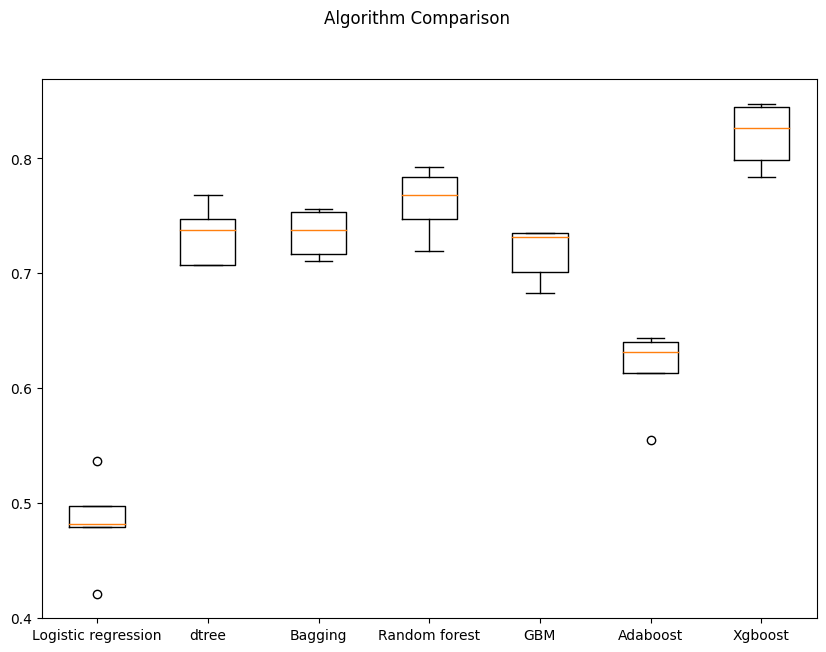

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

**Comments on Model building with original data**


* Recall scores in the validation set range from 0.46 to 0.76 and is not very high

* Most of the models appear to be underfit with low CV score and low score on validation set

* Top 3 models with highest recall on validation set appears to be Random Forest, Decision Tree and XGBoost

* CV scores of most of the models are similar to the scores obtained on the validation set

* This suggests that most of the models seem to generalize reasonably well

* We will evaluate if model performances could be improved by over-sampling or undersampling techniques so that minority class could be predicted better



# Model Building with Oversampled data


* To avoid giving greater preference to the prediction of the majority class i.e Class 0, we are using over-sampling techniques to balance class representation
* Frequency of the Minority Class 1 is increased to provide a more balanced class representation

In [ ]:
# Class size of Training Data Before Over-sampling
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 1640
Before OverSampling, counts of label '0': 28360 



In [ ]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [ ]:
# Class size of Training Data after Over-sampling
print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))

After OverSampling, counts of label '1': 28360
After OverSampling, counts of label '0': 28360 



In [ ]:
# Shape of Training Data after Over-sampling
print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

After OverSampling, the shape of train_X: (56720, 40)
After OverSampling, the shape of train_y: (56720,) 



Comments on Over-sampling Training data:

* Minority Class 1 has only 1640 entries before over-sampling
* After oversampling, Class 1 has 28360 entries, thus making a 50:50 class representations between Class 1 and Class 0
* Lets evaluate if this improves the performance of the ML models

**Oversampled data Model Building**


In [ ]:
models_over = []  # Empty list to store all the models

# Appending models into the list
models_over.append(("Logistic regression", LogisticRegression(random_state=1)))
models_over.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("Random forest", RandomForestClassifier(random_state=1)))
models_over.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_over.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results2 = []  # Empty list to store all model's CV scores
names_over = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results2.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

Logistic regression: 0.8754583921015515
dtree: 0.9722143864598026
Bagging: 0.9730606488011284
Random forest: 0.9817348377997179
GBM: 0.9148095909732017
Adaboost: 0.8933004231311706
Xgboost: 0.9855430183356841

Validation Performance:

Logistic regression: 0.8391224862888482
dtree: 0.8135283363802559
Bagging: 0.8354661791590493
Random forest: 0.8683729433272395
GBM: 0.8811700182815356
Adaboost: 0.850091407678245
Xgboost: 0.8756855575868373


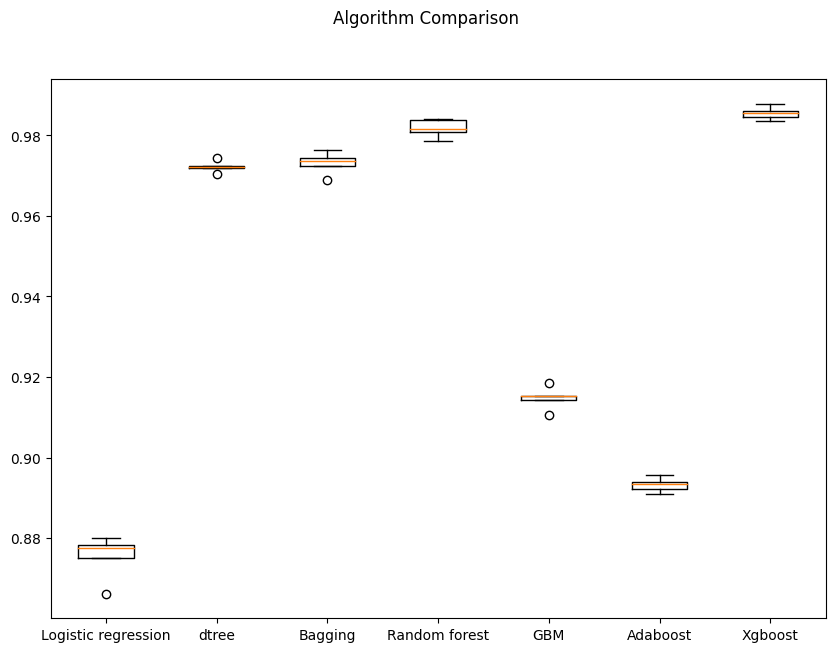

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results2)
ax.set_xticklabels(names_over)

plt.show()

**Comments on Model building with oversampled data**

* There is a significant improvement in the CV scores of all the models compared to the models built using original data

* CV recall scores in the models range from 0.87 to 0.98

* Broadly, the performance of the models seem to have improved using oversampled data

* However, the CV scores of most models seem to be systematically higher than the scores obtained on the validation set suggesting a moderate degree of overfitting

* This suggests that most of the models seems to generalize to some extent but not exceptionally well

* Top 3 models with highest recall on validation set appears to be Gradient Boosting, XGBoost and Random Forest

* Hyperparameter tuning may be helpful to further improve the performances of these models using oversampled data as well as help reduce the amount of overfitting

# Model Building with Undersampled data


* To avoid giving greater preference to the prediction of the majority class i.e Class 0, we are using under-sampling techniques to balance class representation
* Frequency of the Majority Class 0 is decreased to achieve more balanced class representation in undersampling

In [ ]:

# Class size of Training Data Before Undersampling
print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before UnderSampling, counts of label '1': 1640
Before UnderSampling, counts of label '0': 28360 



In [ ]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [ ]:
# Class size of Training Data after Undersampling
print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))

After UnderSampling, counts of label '1': 1640
After UnderSampling, counts of label '0': 1640 



In [ ]:
# Shape of Training Data after Undersampling
print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

After UnderSampling, the shape of train_X: (3280, 40)
After UnderSampling, the shape of train_y: (3280,) 



Undersampled data model building

In [ ]:
models_un = []  # Empty list to store all the models

# Appending models into the list
models_un.append(("Logistic regression", LogisticRegression(random_state=1)))
models_un.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_un.append(("Bagging", BaggingClassifier(random_state=1)))
models_un.append(("Random forest", RandomForestClassifier(random_state=1)))
models_un.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_un.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_un.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results3 = []  # Empty list to store all model's CV scores
names_un = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models_un:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results3.append(cv_result)
    names_un.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_un:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

Logistic regression: 0.8554878048780488
dtree: 0.8591463414634146
Bagging: 0.875
Random forest: 0.8981707317073171
GBM: 0.8871951219512194
Adaboost: 0.8725609756097562
Xgboost: 0.896951219512195

Validation Performance:

Logistic regression: 0.8464351005484461
dtree: 0.8537477148080439
Bagging: 0.8628884826325411
Random forest: 0.8848263254113345
GBM: 0.8884826325411335
Adaboost: 0.8647166361974405
Xgboost: 0.8957952468007313


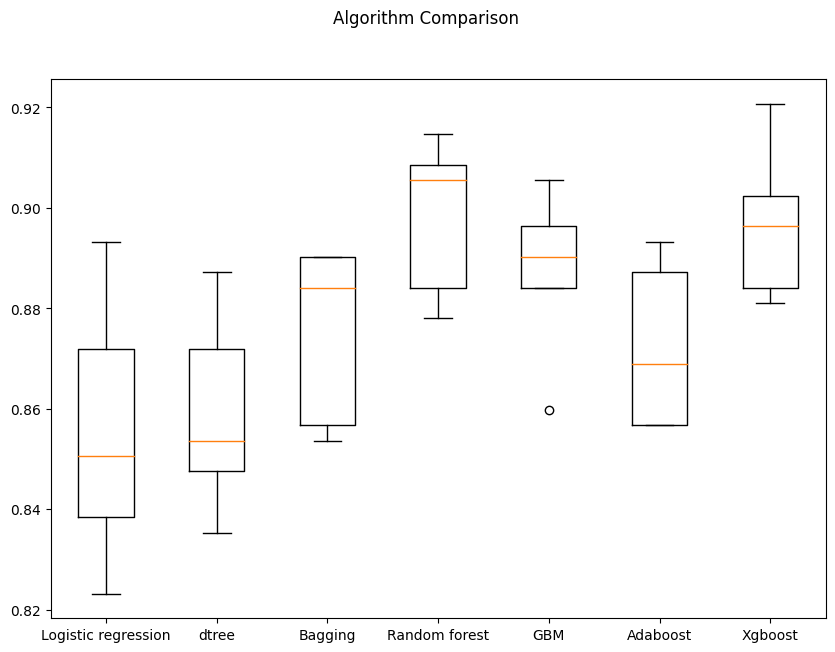

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results3)
ax.set_xticklabels(names_un)

plt.show()

**Comments on Model building with undersampled data**


* There is significant improvement in the CV scores of all the models compared to the models built using original data

* CV recall scores in the models range from 0.85 to 0.9

* The CV scores are generally slightly lower than the equivalent models built using oversampling techniques and thus perform slightly worse compared to models using oversampling

* However, the CV scores of most models seem to be very similar to the scores obtained on the validation set

* This suggests that the models using undersampled data seem to generalize quite well, slightly better than the models built using oversampling

* Top 3 models with highest recall on validation set appears to be Gradient Boosting, Random Forest and XGBoost

* Hyperparameter tuning may be helpful to further improve the performances of these models using undersampled data

# Hyperparameter Tuning


* Hyperparameter tuning can help improve model performance as well help to reduce both overfitting or underfitting

* Generally the default models using the original data with imbalanced classes performs poorly (low recall score) and appears to be underfit (poor performance in both training and validation)

* We can attempt to improve performance using hyperparameter tuning in these models

* Models using oversampling techniques have the best performance but appear to be slightly overfit with validation data scores systematically lower than the CV scores

* We can use hyperparameter tuning to see if we could reduce the overfitting and improve performance

* Models using undersampling techniques have slightly lower performance scores compared to the models using oversampled data but appear to generalize better with very similar CV scores and validation scores.

* We can use hyperparameter tuning to see if we could primarily improve performance

**Approach for Hyperparameter tuning**

* In terms of performance based on CV score alone, few of the top five models are

* Random Forest with oversampled data,
* Bagging classifier with oversampled data,
* Decision Tree with oversampled data,
* Gradient Boosting with oversampled data
* XGB with oversampled data

* However, all of these models suffer from slight overfitting and we will tune hyperparameters to see how much we can improve them and reduce overfitting


* In terms of both performance and model generalization, few of the top five models are

* Random Forest with undersampled data,

* Gradient Boosting with undersampled data,

* XGB with undersampled data,

* Bagging classifier with undersampled data

* Ada Boost with undersampled data

* We will focus on improving performance for these models using hyperparameter tuning

* Instead of selecting just a few models for hyperparameter tuning , we will be tuning 15 models (all models except Bagging Classifier and Ada Boost Classifier) with default, over- and undersampled data with the objective of either

* improve performance and reduce underfitting (Default models)

* reduce overfitting and generalize better as well as further improve performance (Models using oversampled data)

* improve performance (Models using undersampled data)
Bagging Classifier models have been left out from tuning because they are extremely time intensive for computation and produce very poorly generalized, highly overfit models [NOTE: These models were tuned earlier but excluded in final solution]

* Ada Boost Classifier models have been left out from tuning because they are are extremely time intensive for computation and their pre-tuned performance isn't significantly better compared to the other models [NOTE: These models were tuned earlier but excluded in final solution]

**Selection of Top Models for Hyperparamater Tuning**

* Although we will be tuning additional models to see how hyper-parameter tuning affects performance and generalization across different models, we will highlight here top 7 models to be selected in case there are time constraints to tune all models

Top models to select for Hyperparameter tuning are as follows

* (1) Random Forest with Oversampling
* (2) Bagging Classifier with Oversampling
* (3) Gradient Boosting with Oversampling
* (4) XGBoost with Oversampling
* (5) Random Forest with Undersampling
* (6) Gradient Boosting with Undersampling
* (7) XGBoost with Undersampling

Reasons for selection of the above models in scenarios where time is limited and all 21 models cannot be tuned are

* Models (1) to (4) are selected because they perform really well with high recall CV score but suffer from slight overfitting. Hyperparamater tuning may help to generalize them without losing much performance
* Models (5) to (7) are selected because they generalize quite well with relatively high performance. Tuning may help further improve performance without losing generalization
* Model (2) should be skipped if there are time limitations as it is the most computationally expensive amongst these 7 models
NOTE: This is done here for consistency purposes related to the grading rubric

**Sample Parameter Grids**

Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.


* For Gradient Boosting:
param_grid = { "n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7] }

* For Adaboost:
param_grid = { "n_estimators": [100, 150, 200], "learning_rate": [0.2, 0.05], "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1), ] }

* For Bagging Classifier:
param_grid = { 'max_samples': [0.8,0.9,1], 'max_features': [0.7,0.8,0.9], 'n_estimators' : [30,50,70], }

* For Random Forest:
param_grid = { "n_estimators": [200,250,300], "min_samples_leaf": np.arange(1, 4), "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], "max_samples": np.arange(0.4, 0.7, 0.1) }

* For Decision Trees:
param_grid = { 'max_depth': np.arange(2,6), 'min_samples_leaf': [1, 4, 7], 'max_leaf_nodes' : [10, 15], 'min_impurity_decrease': [0.0001,0.001] }

* For Logistic Regression:
param_grid = {'C': np.arange(0.1,1.1,0.1)}

* For XGBoost:
param_grid={ 'n_estimators': [150, 200, 250], 'scale_pos_weight': [5,10], 'learning_rate': [0.1,0.2], 'gamma': [0,3,5], 'subsample': [0.8,0.9] }

**1. Hyperparameter tuning Logistic Regression with original data**

In [ ]:
%%time
# defining model
Model = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'C': 0.1} with CV score=0.48414634146341456:
CPU times: user 740 ms, sys: 290 ms, total: 1.03 s
Wall time: 18.1 s


In [ ]:
# Creating new pipeline with best parameters
tuned_lr1 = LogisticRegression(random_state=1,C=0.1)

tuned_lr1.fit(X_train,y_train)

LogisticRegression(C=0.1, random_state=1)

In [ ]:
# Calculating different metrics on train set
tuned_lr1_train_perf = model_performance_classification_sklearn(tuned_lr1, X_train, y_train)
tuned_lr1_train_perf

,Accuracy,Recall,Precision,F1
0,0.967,0.485,0.853,0.618


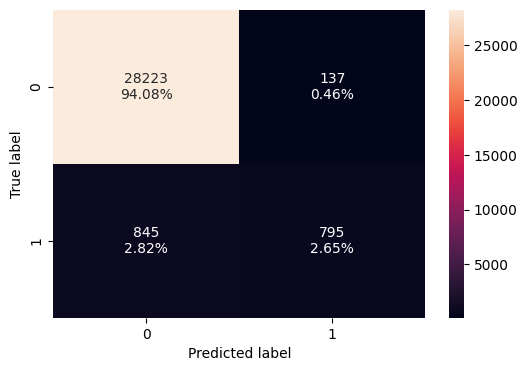

In [ ]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_lr1, X_train, y_train)

In [ ]:
# Calculating different metrics on validation set
tuned_lr1_val_perf = model_performance_classification_sklearn(tuned_lr1, X_val, y_val)
tuned_lr1_val_perf

,Accuracy,Recall,Precision,F1
0,0.966,0.463,0.849,0.599


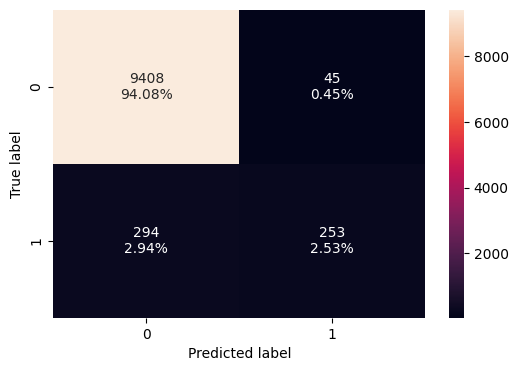

In [ ]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_lr1, X_val, y_val)


**Comments on hyperparameter tuning Logistic regression model with original data**

* Training and validation recall scores are very poor (< 0.5)

* Recall scores is very similar to non-tuned logistic regression models with original data and havent improved

* Model is extremely poor in correctly predicting the minority class (class '1')



**2. Hyperparameter tuning Logistic Regression with oversampled data**

In [ ]:
%%time
# defining model
Model = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'C': 0.1} with CV score=0.8755641748942173:
CPU times: user 2.26 s, sys: 1.98 s, total: 4.25 s
Wall time: 42.7 s


In [ ]:
# Creating new pipeline with best parameters
tuned_lr2 = LogisticRegression(random_state=1,C=0.1)

tuned_lr2.fit(X_train_over,y_train_over)

LogisticRegression(C=0.1, random_state=1)

In [ ]:
# Calculating different metrics on train set
tuned_lr2_train_perf = model_performance_classification_sklearn(tuned_lr2, X_train_over, y_train_over)
tuned_lr2_train_perf

,Accuracy,Recall,Precision,F1
0,0.874,0.876,0.873,0.874


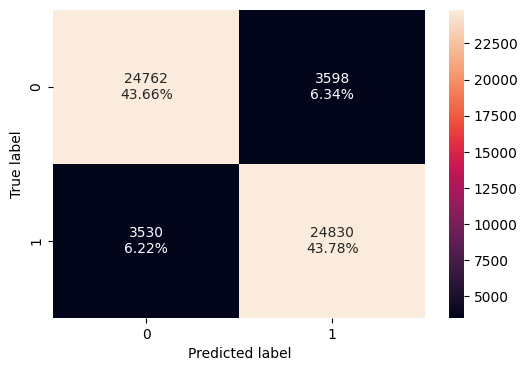

In [ ]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_lr2, X_train_over, y_train_over)


In [ ]:
# Calculating different metrics on validation set
tuned_lr2_val_perf = model_performance_classification_sklearn(tuned_lr2, X_val, y_val)
tuned_lr2_val_perf

,Accuracy,Recall,Precision,F1
0,0.873,0.839,0.279,0.419


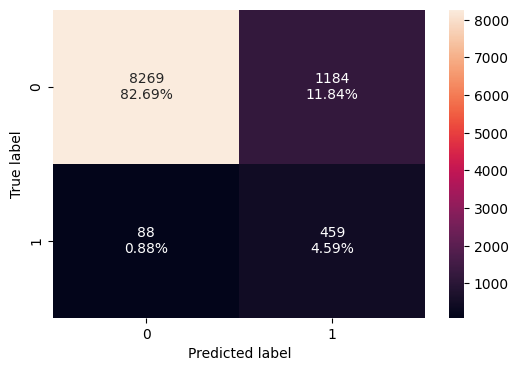

In [ ]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_lr2, X_val, y_val)


**Comments on hyperparameter tuning Logistic regression model with oversampled data**

* Recall has significantly improved to 0.84 in validation set compared to the model using original data

* Training and validation set recall scores are similar suggesting reasonable model generalization with respect to recall

* Precision and F1 score are quite poor (0.28 and 0.42) in validation set and much lower compared to the scores in training set

* This suggests that the model performance and generalization are both very poor with respect to precision and F1 score

**3. Hyperparameter tuning Logistic Regression with undersampled data**


In [ ]:
%%time
# defining model
Model = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'C': 0.1} with CV score=0.8585365853658538:
CPU times: user 211 ms, sys: 22 ms, total: 233 ms
Wall time: 2.09 s


In [ ]:
# Creating new pipeline with best parameters
tuned_lr3 = LogisticRegression(random_state=1,C=0.1)

tuned_lr3.fit(X_train_un,y_train_un)

LogisticRegression(C=0.1, random_state=1)

In [ ]:
# Calculating different metrics on train set
tuned_lr3_train_perf = model_performance_classification_sklearn(tuned_lr3, X_train_un, y_train_un)
tuned_lr3_train_perf

,Accuracy,Recall,Precision,F1
0,0.859,0.856,0.862,0.859


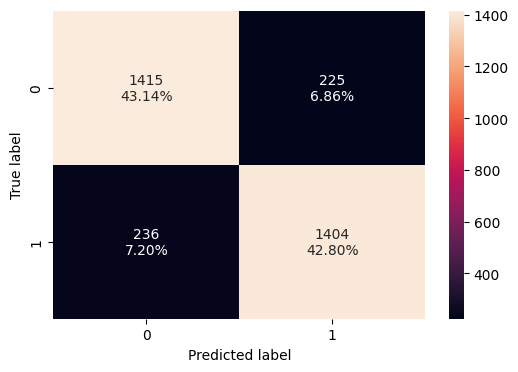

In [ ]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_lr3, X_train_un, y_train_un)


In [ ]:
# Calculating different metrics on validation set
tuned_lr3_val_perf = model_performance_classification_sklearn(tuned_lr3, X_val, y_val)
tuned_lr3_val_perf

,Accuracy,Recall,Precision,F1
0,0.864,0.846,0.266,0.405


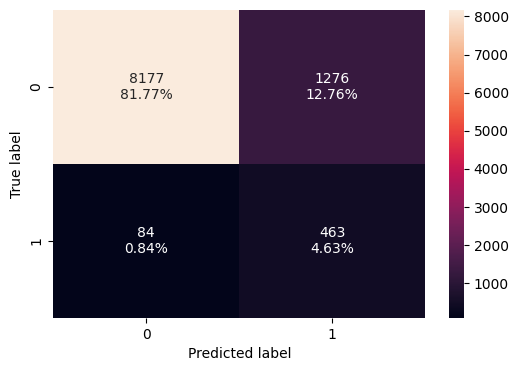

In [ ]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_lr3, X_val, y_val)


**Comments on hyperparameter tuning Logistic regression model with undersampled data**
* Recall in validation set is very similar to model using oversampling

* Model seems to generalize well with respect to recall score

* Precision and F1 score are very poor (0.26 and 0.405) in validation set and much lower compared to the scores in training set

* This suggests that the model performance and generalization are both very poor with respect to precision and F1 score



**4. Hyperparameter tuning Decision tree with original data**


In [ ]:
%%time
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': 5} with CV score=0.6067073170731707:
CPU times: user 1.9 s, sys: 109 ms, total: 2.01 s
Wall time: 37.8 s


In [ ]:
# Creating new pipeline with best parameters
tuned_dt1 = DecisionTreeClassifier(random_state=1,min_samples_leaf=7, min_impurity_decrease = 0.0001, max_leaf_nodes = 15, max_depth = 5)

tuned_dt1.fit(X_train,y_train)


DecisionTreeClassifier(max_depth=5, max_leaf_nodes=15,
                       min_impurity_decrease=0.0001, min_samples_leaf=7,
                       random_state=1)

In [ ]:
# Calculating different metrics on train set
tuned_dt1_train_perf = model_performance_classification_sklearn(tuned_dt1, X_train, y_train)
tuned_dt1_train_perf


,Accuracy,Recall,Precision,F1
0,0.975,0.654,0.861,0.744


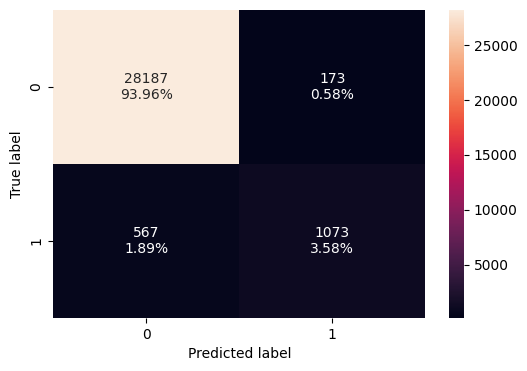

In [ ]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_dt1, X_train, y_train)


In [ ]:
# Calculating different metrics on validation set
tuned_dt1_val_perf = model_performance_classification_sklearn(tuned_dt1, X_val, y_val)
tuned_dt1_val_perf

,Accuracy,Recall,Precision,F1
0,0.974,0.644,0.846,0.731


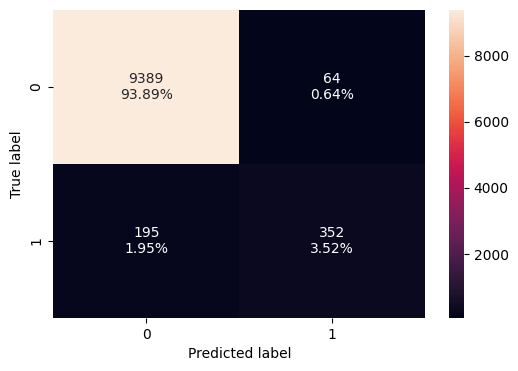

In [ ]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_dt1, X_val, y_val)


**Comments on hyperparameter tuning Decision Tree model with original data**

* Recall score is not very high (~0.65)

* Recall scores is poorer compared to pre-tuned models and this may partly arise from the range of parameters in the parameter grid and the use of Randomized grid search as opposed to the more extensive grid search

* Model generalizes well with respect to most performance metrics and is not very overfit

**5. Hyperparameter tuning Decision tree with oversampled data**

In [ ]:
%%time
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': 5} with CV score=0.8526093088857545:
CPU times: user 4.48 s, sys: 504 ms, total: 4.99 s
Wall time: 1min 27s


In [ ]:
# Creating new pipeline with best parameters
tuned_dt2 = DecisionTreeClassifier(random_state=1,min_samples_leaf=7, min_impurity_decrease = 0.0001, max_leaf_nodes = 15, max_depth = 5)

tuned_dt2.fit(X_train_over,y_train_over)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=15,
                       min_impurity_decrease=0.0001, min_samples_leaf=7,
                       random_state=1)

In [ ]:
# Calculating different metrics on train set
tuned_dt2_train_perf = model_performance_classification_sklearn(tuned_dt2, X_train_over, y_train_over)
tuned_dt2_train_perf

,Accuracy,Recall,Precision,F1
0,0.896,0.858,0.929,0.892


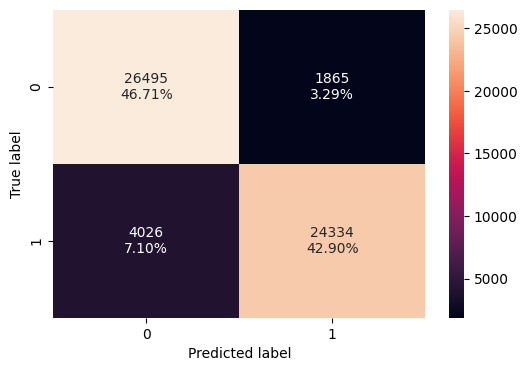

In [ ]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_dt2, X_train_over, y_train_over)

In [ ]:
# Calculating different metrics on validation set
tuned_dt2_val_perf = model_performance_classification_sklearn(tuned_dt2, X_val, y_val)
tuned_dt2_val_perf

,Accuracy,Recall,Precision,F1
0,0.924,0.808,0.404,0.539


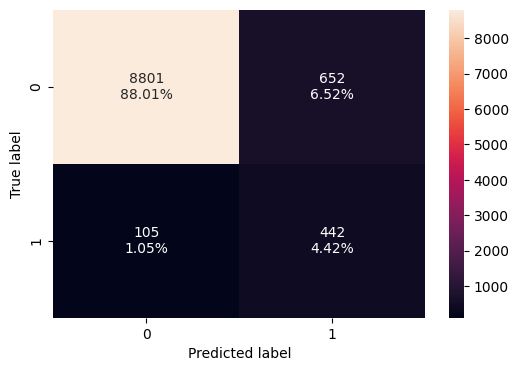

In [ ]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_dt2, X_val, y_val)

**Comments on hyperparameter tuning Decision Tree model with oversampled data**

* Recall score has improved to 0.81 in validation set compared to model built with original data

* Model appears slightly overfit with respect to recall with validation score slightly lower compared to training set score

* Model appears quite overfit with respect to precision and F1 score with model performing poorly on validation data

**6. Hyperparameter tuning Decision tree with undersampled data**

In [ ]:
%%time
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,20),
              'min_samples_leaf': [1, 2, 5, 7],
              'max_leaf_nodes' : [5, 10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 1, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 11} with CV score=0.8292682926829269:
CPU times: user 330 ms, sys: 24 ms, total: 354 ms
Wall time: 4.01 s


In [ ]:
# Creating new pipeline with best parameters
tuned_dt3 = DecisionTreeClassifier(random_state=1,min_samples_leaf=1, min_impurity_decrease = 0.001, max_leaf_nodes = 15, max_depth = 11)

tuned_dt3.fit(X_train_un,y_train_un)

DecisionTreeClassifier(max_depth=11, max_leaf_nodes=15,
                       min_impurity_decrease=0.001, random_state=1)

In [ ]:
# Calculating different metrics on train set
tuned_dt3_train_perf = model_performance_classification_sklearn(tuned_dt3, X_train_un, y_train_un)
tuned_dt3_train_perf

,Accuracy,Recall,Precision,F1
0,0.898,0.851,0.938,0.893


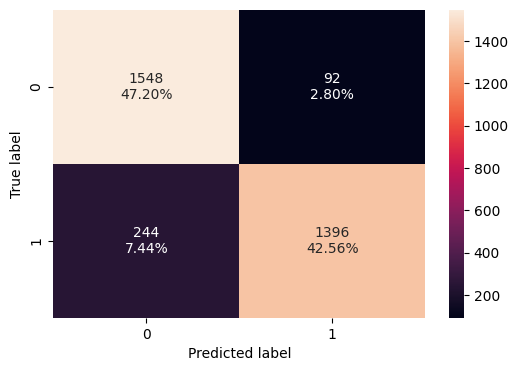

In [ ]:
#confusion matrix on train set
confusion_matrix_sklearn(tuned_dt3, X_train_un, y_train_un)

In [ ]:
# Calculating different metrics on validation set
tuned_dt3_val_perf = model_performance_classification_sklearn(tuned_dt3, X_val, y_val)
tuned_dt3_val_perf

,Accuracy,Recall,Precision,F1
0,0.912,0.804,0.362,0.500


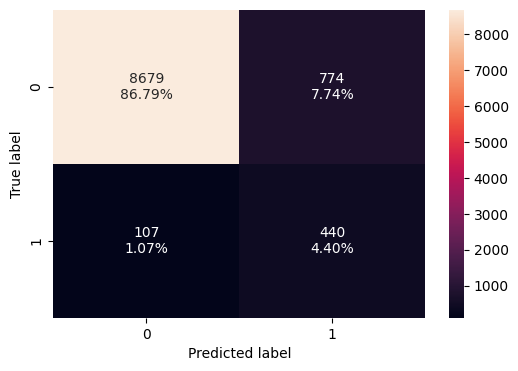

In [ ]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_dt3, X_val, y_val)

**Comments on hyperparameter tuning Decision Tree model with undersampled data**

* Recall score in validation set is similar to oversampled data model

* Model appears slightly overfit with respect to recall with validation score slightly lower compared to training score

* Model is very overfit with respect to precision and F1 score with model performing poorly on validation data

* Limited range of hyperparameters and use of Randomized Grid search may be responsible for similar poor performances in models using oversampled and undersampled techniques

**7. Hyperparameter tuning Random Forest Classifer with original data**

In [ ]:
%%time
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.749390243902439:
CPU times: user 1min 34s, sys: 2.46 s, total: 1min 37s
Wall time: 24min 49s


In [ ]:
# Creating new pipeline with best parameters
tuned_rf1 = RandomForestClassifier(random_state=1,n_estimators = 300, min_samples_leaf = 1, max_samples = 0.6, max_features = 'sqrt')

tuned_rf1.fit(X_train,y_train)

RandomForestClassifier(max_samples=0.6, n_estimators=300, random_state=1)

In [ ]:
# Calculating different metrics on train set
tuned_rf1_train_perf = model_performance_classification_sklearn(tuned_rf1, X_train, y_train)
tuned_rf1_train_perf

,Accuracy,Recall,Precision,F1
0,0.995,0.904,0.998,0.949


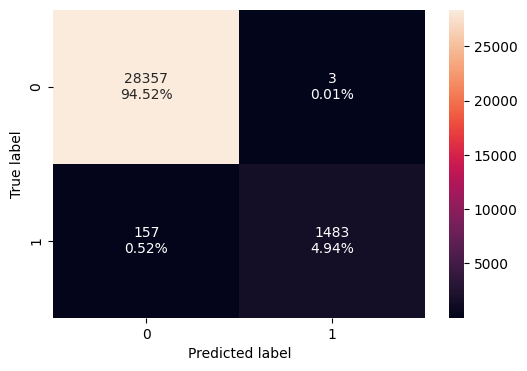

In [ ]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_rf1, X_train, y_train)

In [ ]:
# Calculating different metrics on validation set
tuned_rf1_val_perf = model_performance_classification_sklearn(tuned_rf1, X_val, y_val)
tuned_rf1_val_perf

,Accuracy,Recall,Precision,F1
0,0.986,0.751,0.990,0.854


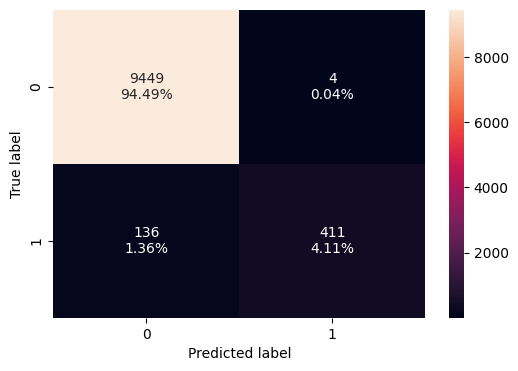

In [ ]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_rf1, X_val, y_val)

**Comments on hyperparameter tuning Random Forest model with original data**

* Model appears to be overfitting with respect to recall score

* Model validation recall is very similar to pre-tuned model and not much improved

* Model precision and accuracy is high and generalizes well but the model does a poorer job in predicting the minority class

**8. Hyperparameter tuning Random Forest Classifer with oversampled data**


In [ ]:
%%time
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9780324400564175:
CPU times: user 1min 53s, sys: 3.71 s, total: 1min 57s
Wall time: 33min 12s


In [ ]:
# Creating new pipeline with best parameters
tuned_rf2 = RandomForestClassifier(random_state=1,n_estimators = 250, min_samples_leaf = 1, max_samples = 0.6, max_features = 'sqrt')

tuned_rf2.fit(X_train_over,y_train_over)

RandomForestClassifier(max_samples=0.6, n_estimators=250, random_state=1)

In [ ]:
# Calculating different metrics on train set
tuned_rf2_train_perf = model_performance_classification_sklearn(tuned_rf2, X_train_over, y_train_over)
tuned_rf2_train_perf


,Accuracy,Recall,Precision,F1
0,1.000,0.999,1.000,1.000


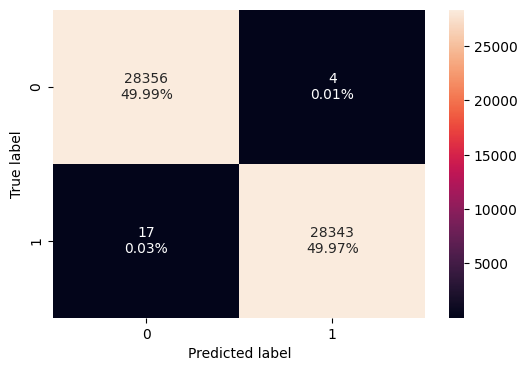

In [ ]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_rf2, X_train_over, y_train_over)

In [ ]:
# Calculating different metrics on validation set
tuned_rf2_val_perf = model_performance_classification_sklearn(tuned_rf2, X_val, y_val)
tuned_rf2_val_perf

,Accuracy,Recall,Precision,F1
0,0.990,0.872,0.948,0.909


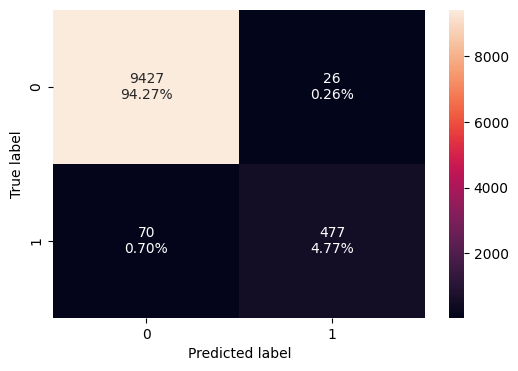

In [ ]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_rf2, X_val, y_val)

**Comments on hyperparameter tuning Random Forest Classifier model with Oversampled data**

* Model performs very well on the validation set with very high performance metrics

* However the model appears to be slightly overfit with near perfect training scores but slightly lower scores on the validation set (Training recall is ~1; Validation recall is 0.87)

* Model generalizes reasonably well but not great

* Model performance is similar to pre-tuned random forest model with oversampled data

**9. Hyperparameter tuning Random Forest Classifer with undersampled data**


In [ ]:
%%time
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'n_estimators': 200, 'min_samples_leaf': 2, 'max_samples': 0.4, 'max_features': 'sqrt'} with CV score=0.899390243902439:
CPU times: user 4.12 s, sys: 302 ms, total: 4.42 s
Wall time: 2min 5s


In [ ]:
# Creating new pipeline with best parameters
tuned_rf3 = RandomForestClassifier(random_state=1, n_estimators = 200, min_samples_leaf = 2, max_samples = 0.4, max_features = 'sqrt')

tuned_rf3.fit(X_train_un,y_train_un)

RandomForestClassifier(max_samples=0.4, min_samples_leaf=2, n_estimators=200,
                       random_state=1)

In [ ]:
# Calculating different metrics on train set
tuned_rf3_train_perf = model_performance_classification_sklearn(tuned_rf3, X_train_un, y_train_un)
tuned_rf3_train_perf

,Accuracy,Recall,Precision,F1
0,0.955,0.921,0.988,0.954


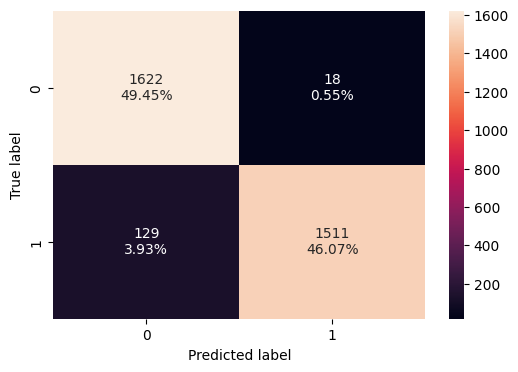

In [ ]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_rf3, X_train_un, y_train_un)


In [ ]:
# Calculating different metrics on validation set
tuned_rf3_val_perf = model_performance_classification_sklearn(tuned_rf3, X_val, y_val)
tuned_rf3_val_perf

,Accuracy,Recall,Precision,F1
0,0.960,0.890,0.590,0.710


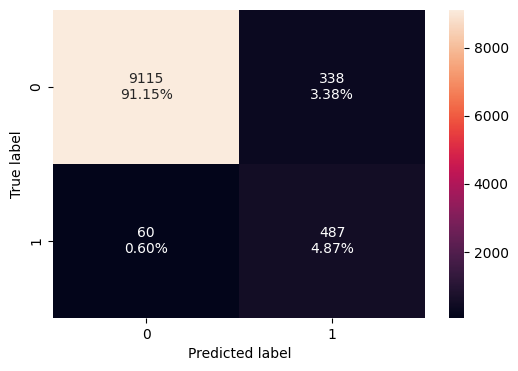

In [ ]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_rf3, X_val, y_val)

**Comments on hyperparameter tuning Random Forest Classifier model with Undersampled data**

* Model performs very well on the validation set with respect to accuracy and recall and appears to generalize with respect to these metrics as well

* Model appears to be quite overfit with respect to precision and F1 score and does not generalize

**10. Hyperparameter tuning Gradient Boosting Classifer with original data**


In [ ]:
%%time
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}
#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.7585365853658537:
CPU times: user 35.2 s, sys: 1.44 s, total: 36.7 s
Wall time: 13min 10s


In [ ]:
# Creating new pipeline with best parameters
tuned_gb1 = GradientBoostingClassifier(random_state=1, subsample = 0.7, n_estimators = 125, max_features = 0.5, learning_rate = 0.2)

tuned_gb1.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.7)

In [ ]:
# Calculating different metrics on train set
tuned_gb1_train_perf = model_performance_classification_sklearn(tuned_gb1, X_train, y_train)
tuned_gb1_train_perf

,Accuracy,Recall,Precision,F1
0,0.990,0.823,0.985,0.896


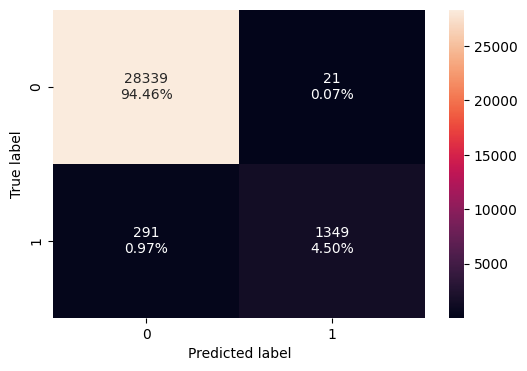

In [ ]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_gb1, X_train, y_train)

In [ ]:
# Calculating different metrics on validation set
tuned_gb1_val_perf = model_performance_classification_sklearn(tuned_gb1, X_val, y_val)
tuned_gb1_val_perf

**Comments on hyperparameter tuning Gradient Boosting Classifier model with Original data**

* Model has a decent but not great recall score on validation set (0.75)

* Model appears to be slightly overfit with respect to recall and F1 score and generalizes reasonably well but not great.

* Model has very high accuracy and precision on validation set and generalizes well with respect to these metrics

**11. Hyperparameter tuning Gradient Boosting Classifer with oversampled data**


In [ ]:
%%time
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9556064880112836:
CPU times: user 1min 13s, sys: 3.22 s, total: 1min 16s
Wall time: 26min 28s


In [125]:
# Creating new pipeline with best parameters
tuned_gb2 = GradientBoostingClassifier(random_state=1, subsample = 0.7, n_estimators = 125, max_features = 0.5, learning_rate = 1)

tuned_gb2.fit(X_train_over,y_train_over)


GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           random_state=1, subsample=0.7)

In [ ]:
# Calculating different metrics on train set
tuned_gb2_train_perf = model_performance_classification_sklearn(tuned_gb2, X_train_over, y_train_over)
tuned_gb2_train_perf

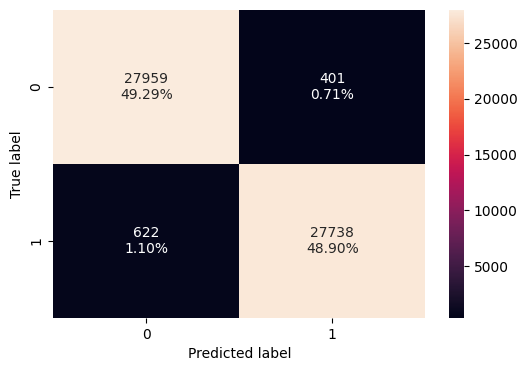

In [ ]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_gb2, X_train_over, y_train_over)


In [ ]:
# Calculating different metrics on validation set
tuned_gb2_val_perf = model_performance_classification_sklearn(tuned_gb2, X_val, y_val)
tuned_gb2_val_perf

,Accuracy,Recall,Precision,F1
0,0.966,0.888,0.636,0.741


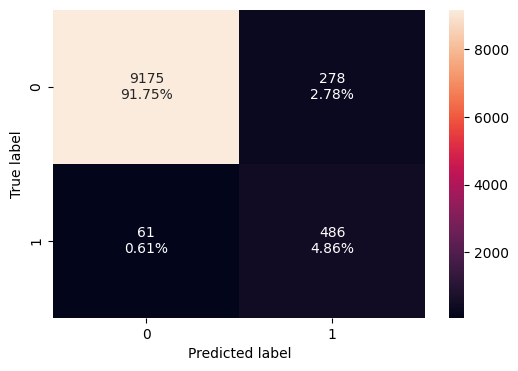

In [ ]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_gb2, X_val, y_val)


**Comments on hyperparameter tuning Gradient Boosting Classifier model with Oversampled data**

* Model has high accuracy and recall but pays the price in precision and F1 score on the validation set

* Model appears overfitting particularly in respect to precision and F1 score but should generalize reasonably well with respect to recall and accuracy

**12. Hyperparameter tuning Gradient Boosting Classifer with undersampled data**


In [126]:
%%time
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'subsample': 0.5, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.9030487804878049:
CPU times: user 2.75 s, sys: 218 ms, total: 2.97 s
Wall time: 1min 14s


In [ ]:
# Creating new pipeline with best parameters
tuned_gb3 = GradientBoostingClassifier(random_state=1, subsample = 0.5, n_estimators = 125, max_features = 0.5, learning_rate = 0.2)

tuned_gb3.fit(X_train_un,y_train_un)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.5)

In [ ]:
# Calculating different metrics on train set
tuned_gb3_train_perf = model_performance_classification_sklearn(tuned_gb3, X_train_un, y_train_un)
tuned_gb3_train_perf

,Accuracy,Recall,Precision,F1
0,0.977,0.960,0.993,0.976


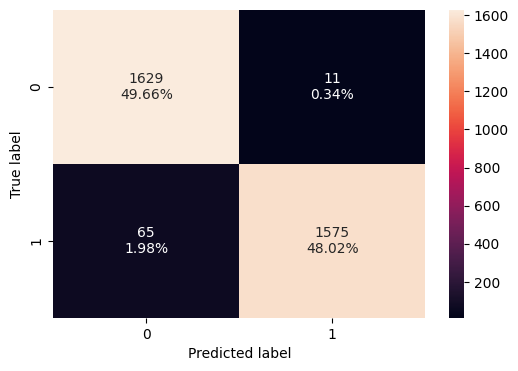

In [ ]:

#Confusion matrix on train set
confusion_matrix_sklearn(tuned_gb3, X_train_un, y_train_un)

In [ ]:
# Calculating different metrics on validation set
tuned_gb3_val_perf = model_performance_classification_sklearn(tuned_gb3, X_val, y_val)
tuned_gb3_val_perf

,Accuracy,Recall,Precision,F1
0,0.935,0.894,0.452,0.600


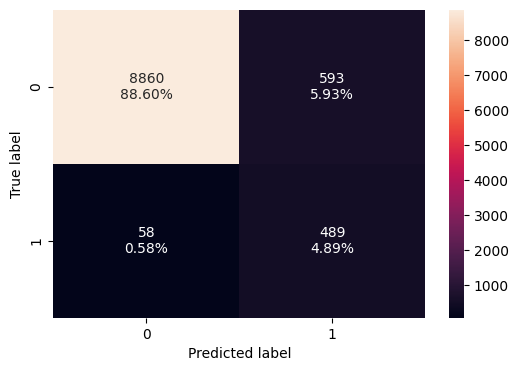

In [ ]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_gb3, X_val, y_val)

**Comments on hyperparameter tuning Gradient Boosting Classifier model with Undersampled data**
* Model has high accuracy and recall but pays the price in precision and F1 score on the validation set

* Model appears very overfit in respect to precision and F1 score but should generalize reasonably well with respect to recall and accuracy

**13. Hyperparameter tuning XGBoost Classifer with original data**


In [127]:
%%time
# defining model
Model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 150, 'learning_rate': 0.1, 'gamma': 3} with CV score=0.8621951219512194:
CPU times: user 6.38 s, sys: 286 ms, total: 6.67 s
Wall time: 1min 58s


In [128]:
# Creating new pipeline with best parameters
tuned_xgb1 = XGBClassifier(random_state=1, subsample = 0.9, scale_pos_weight = 10, n_estimators = 150, learning_rate = 0.2, gamma = 3)

tuned_xgb1.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [129]:
# Calculating different metrics on train set
tuned_xgb1_train_perf = model_performance_classification_sklearn(tuned_xgb1, X_train, y_train)
tuned_xgb1_train_perf

,Accuracy,Recall,Precision,F1
0,0.999,1.000,0.983,0.992


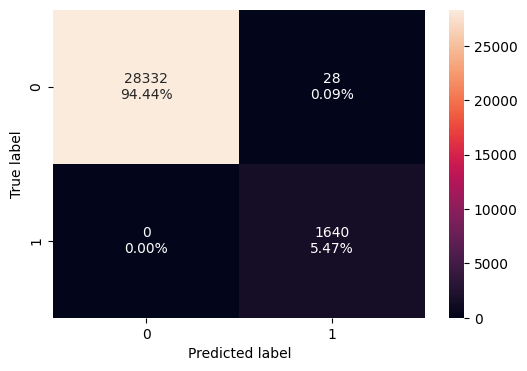

In [130]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_xgb1, X_train, y_train)

In [131]:
# Calculating different metrics on validation set
tuned_xgb1_val_perf = model_performance_classification_sklearn(tuned_xgb1, X_val, y_val)
tuned_xgb1_val_perf

,Accuracy,Recall,Precision,F1
0,0.990,0.865,0.952,0.906


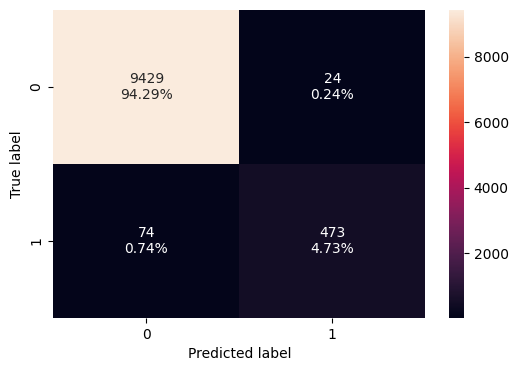

In [132]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_xgb1, X_val, y_val)

**Comments on hyperparameter tuning XGBoost Classifier model with Original data**
* Model performs really well with most performance metrics with validation recall score of 0.88

* Model also generalizes quite well with most metrics particulary accuracy and precision

* Model recall is significantly improved from the non-tuned XG Boost model using original data

**14. Hyperparameter tuning XGBoost Classifer with oversampled data**


In [133]:
%%time
# defining model
Model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.1, 'gamma': 0} with CV score=0.9962623413258109:
CPU times: user 17 s, sys: 989 ms, total: 18 s
Wall time: 4min 38s


In [134]:
# Creating new pipeline with best parameters
tuned_xgb2 = XGBClassifier(random_state=1, subsample = 0.9, scale_pos_weight = 10, n_estimators = 200, learning_rate = 0.2, gamma = 0)

tuned_xgb2.fit(X_train_over,y_train_over)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [135]:
# Calculating different metrics on train set
tuned_xgb2_train_perf = model_performance_classification_sklearn(tuned_xgb2, X_train_over, y_train_over)
tuned_xgb2_train_perf


,Accuracy,Recall,Precision,F1
0,0.999,1.000,0.998,0.999


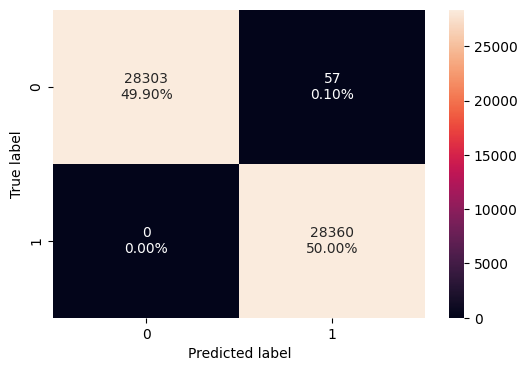

In [136]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_xgb2, X_train_over, y_train_over)


In [137]:
# Calculating different metrics on validation set
tuned_xgb2_val_perf = model_performance_classification_sklearn(tuned_xgb2, X_val, y_val)
tuned_xgb2_val_perf


,Accuracy,Recall,Precision,F1
0,0.983,0.898,0.814,0.854


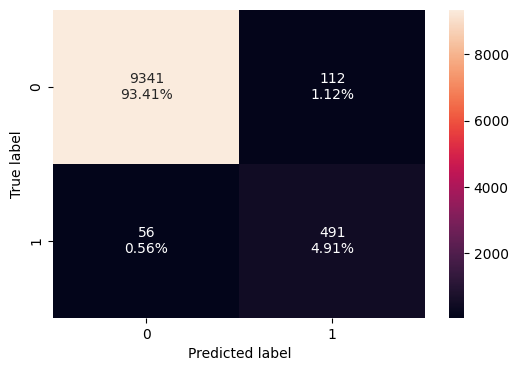

In [138]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_xgb2, X_val, y_val)


**Comments on hyperparameter tuning XGBoost Classifier model with Oversampled data**
* Model performs really well with respect to recall in validation set (0.92)

* Model shows decent generalization with respect to accuracy and recall

* Model appears to be very overfit with respect to precision and F1 score

* Model recall score on the validation set is improved from the non-tuned XGB model with oversampled data

**15. Hyperparameter tuning XGBoost Classifer with undersampled data**


In [139]:
%%time
# defining model
Model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9243902439024391:
CPU times: user 2.34 s, sys: 116 ms, total: 2.46 s
Wall time: 46.1 s


In [140]:
# Creating new pipeline with best parameters
tuned_xgb3 = XGBClassifier(random_state=1, subsample = 0.8, scale_pos_weight = 10, n_estimators = 150, learning_rate = 0.1, gamma = 3)

tuned_xgb3.fit(X_train_un,y_train_un)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [141]:
# Calculating different metrics on train set
tuned_xgb3_train_perf = model_performance_classification_sklearn(tuned_xgb3, X_train_un, y_train_un)
tuned_xgb3_train_perf


,Accuracy,Recall,Precision,F1
0,0.994,1.000,0.988,0.994


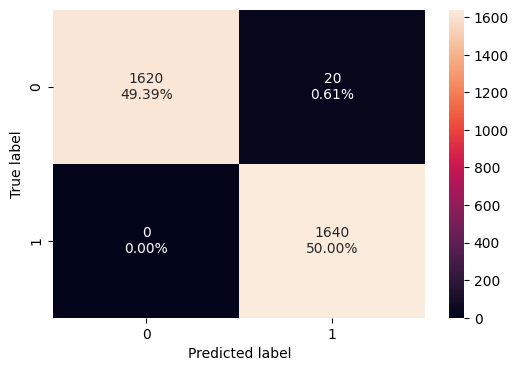

In [142]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_xgb3, X_train_un, y_train_un)


In [143]:
# Calculating different metrics on validation set
tuned_xgb3_val_perf = model_performance_classification_sklearn(tuned_xgb3, X_val, y_val)
tuned_xgb3_val_perf

,Accuracy,Recall,Precision,F1
0,0.900,0.920,0.345,0.502


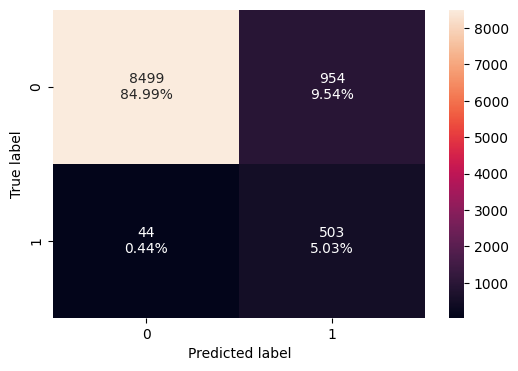

In [144]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_xgb3, X_val, y_val)


**Comments on hyperparameter tuning XGBoost Classifier model with Undersampled data**
* Model performs really well with respect to recall in validation set (0.94)

* Model shows decent generalization with respect to recall score in validation set

* Model appears to be extremely overfit with respect to precision and F1 score and overfit with respect to accuracy

* Model recall score on the validation set is improved from the non-tuned XGB model with oversampled data

# Model performance comparison and choosing the final model


Training Performance comparison


In [145]:
# Model Name as Index
index = pd.Index(
    [
        "Log_Reg_Tuned",
        "Log_Reg_Tuned_Over",
        "Log_Reg_Tuned_Under",
        "Decision_Tree_Tuned",
        "Decision_Tree_Tuned_Over",
        "Decision_Tree_Tuned_Under",
        "Random_Forest_Tuned",
        "Random_Forest_Tuned_Over",
        "Random_Forest_Tuned_Under",
        "Gradient_Boost_Tuned",
        "Gradient_Boost_Tuned_Over",
        "Gradient_Boost_Tuned_Under",
        "XGBoost_Tuned",
        "XGBoost_Tuned_Over",
        "XGBoost_Tuned_Under",

    ]
)
# Create DataFrame with different models as rows, and performance metrics as columns
model_train_perf_comp = pd.concat(
    [
        tuned_lr1_train_perf,
        tuned_lr2_train_perf,
        tuned_lr3_train_perf,
        tuned_dt1_train_perf,
        tuned_dt2_train_perf,
        tuned_dt3_train_perf,
        tuned_rf1_train_perf,
        tuned_rf2_train_perf,
        tuned_rf3_train_perf,
        tuned_gb1_train_perf,
        tuned_gb2_train_perf,
        tuned_gb3_train_perf,
        tuned_xgb1_train_perf,
        tuned_xgb2_train_perf,
        tuned_xgb3_train_perf,

    ],
    ignore_index=True,
)

# set model names as index
model_train_perf_comp = model_train_perf_comp.set_index(index)

print('*'*50)
print("Training Performance Comparison between models")
print('*'*50)
print("\n ")
print("-"*100)
model_train_perf_comp

**************************************************
Training Performance Comparison between models
**************************************************

 
----------------------------------------------------------------------------------------------------


,Accuracy,Recall,Precision,F1
Log_Reg_Tuned,0.967,0.485,0.853,0.618
Log_Reg_Tuned_Over,0.874,0.876,0.873,0.874
Log_Reg_Tuned_Under,0.859,0.856,0.862,0.859
Decision_Tree_Tuned,0.975,0.654,0.861,0.744
Decision_Tree_Tuned_Over,0.896,0.858,0.929,0.892
Decision_Tree_Tuned_Under,0.898,0.851,0.938,0.893
Random_Forest_Tuned,0.995,0.904,0.998,0.949
Random_Forest_Tuned_Over,1.000,0.999,1.000,1.000
Random_Forest_Tuned_Under,0.955,0.921,0.988,0.954
Gradient_Boost_Tuned,0.990,0.823,0.985,0.896


Validation Performance Comparison


In [146]:
# Model Name as Index
index = pd.Index(
    [
        "Log_Reg_Tuned",
        "Log_Reg_Tuned_Over",
        "Log_Reg_Tuned_Under",
        "Decision_Tree_Tuned",
        "Decision_Tree_Tuned_Over",
        "Decision_Tree_Tuned_Under",
        "Random_Forest_Tuned",
        "Random_Forest_Tuned_Over",
        "Random_Forest_Tuned_Under",
        "Gradient_Boost_Tuned",
        "Gradient_Boost_Tuned_Over",
        "Gradient_Boost_Tuned_Under",
        "XGBoost_Tuned",
        "XGBoost_Tuned_Over",
        "XGBoost_Tuned_Under",

    ]
)
# Create DataFrame with different models as rows, and performance metrics as columns
model_val_perf_comp = pd.concat(
    [
        tuned_lr1_val_perf,
        tuned_lr2_val_perf,
        tuned_lr3_val_perf,
        tuned_dt1_val_perf,
        tuned_dt2_val_perf,
        tuned_dt3_val_perf,
        tuned_rf1_val_perf,
        tuned_rf2_val_perf,
        tuned_rf3_val_perf,
        tuned_gb1_val_perf,
        tuned_gb2_val_perf,
        tuned_gb3_val_perf,
        tuned_xgb1_val_perf,
        tuned_xgb2_val_perf,
        tuned_xgb3_val_perf,

    ],
    ignore_index=True,
)

# set model names as index
model_val_perf_comp = model_val_perf_comp.set_index(index)

print('*'*50)
print("Validation Performance Comparison between models")
print('*'*50)
print("\n")
print("-"*100)
model_val_perf_comp

**************************************************
Validation Performance Comparison between models
**************************************************


----------------------------------------------------------------------------------------------------


,Accuracy,Recall,Precision,F1
Log_Reg_Tuned,0.966,0.463,0.849,0.599
Log_Reg_Tuned_Over,0.873,0.839,0.279,0.419
Log_Reg_Tuned_Under,0.864,0.846,0.266,0.405
Decision_Tree_Tuned,0.974,0.644,0.846,0.731
Decision_Tree_Tuned_Over,0.924,0.808,0.404,0.539
Decision_Tree_Tuned_Under,0.912,0.804,0.362,0.500
Random_Forest_Tuned,0.986,0.751,0.990,0.854
Random_Forest_Tuned_Over,0.990,0.872,0.948,0.909
Random_Forest_Tuned_Under,0.960,0.890,0.590,0.710
Gradient_Boost_Tuned,0.984,0.750,0.949,0.838


**Summary of Performances of all tuned Models
Most of the models performs really well in terms of accuracy metric (~ > 0.9 in most models)**

* Most of the models also generalize quite well in terms of data accuracy

* In terms of recall, most of the models using oversampled and undersampled data outperforms the models using original data

* This isn't suprising given that these sampling techniques help improve the predictive power of the model on the minority class - Class 1

* Most of the models also generalize relatively well in terms of recall metric

* Most of the models using original data seem to generalize much better in terms of precision and F1 score compared to models using oversampled and undersampled data

* Most of the models using oversampled and undersampled data seem to be overfit in terms of precision and F1 score

* This is likely partly due to the emphasis on using recall as a scorer during cross validation which forces the models to correctly predict the minority class sometimes at the cost of incorrectly predicting the majority class when using over- and undersampling

* All of the 3 XGBoost Classifier model performs the best in terms of recall in the validation set data but the oversampling and undersampling models do not generalize very well in terms of F1 score and precision

* Top 2 models from all the tuned models that perform reasonably well on most metrics as well as generalizes are

* Tuned Random Forest Classifier using Oversampled data
Tuned XGBoost Classifier using original data

**Final Model Selection**

* In terms of selecting the final model to be sent for production, emphasis was given in choosing a model that had the following attributes

* Model performs quite well in terms of recall as the largest priority is to predict the minority class accurately
* Model generalizes quite well and do not suffer from overfitting in terms of recall so that model in production will perform well with unseen data
* Model generalizes reasonably well in terms of other metrics such as precision and F1 score so that the model does not perform poorly with unseen data on those metrics and have fewer incorrect predictions
* Top 2 models from all the tuned models that meet the aforementioned criteria were the following

* (1) Tuned Random Forest Classifier using Oversampled data
* (2) Tuned XGBoost Classifier using original data
* XGBoost Classifier using Original Data is chosen as the final model because of the following reasons:

* It has slightly higher recall score compared to the other model
* It generalizes slightly better in terms of recall with the other top model
It generalizes better in terms of accuracy, precision and F1 score relative to the other top model
* It is computationally less time intensive compared to the other top model
* Wall time of only 10 min 42 s
Random Forest with Oversampled data has wall time of 27 mins and 38 s


**Test set performance on Final Model**


In [147]:
# Calculating different metrics on the test set
model_test = model_performance_classification_sklearn(tuned_xgb1, X_test, y_test)
print("Test performance:")
model_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.989,0.848,0.943,0.893


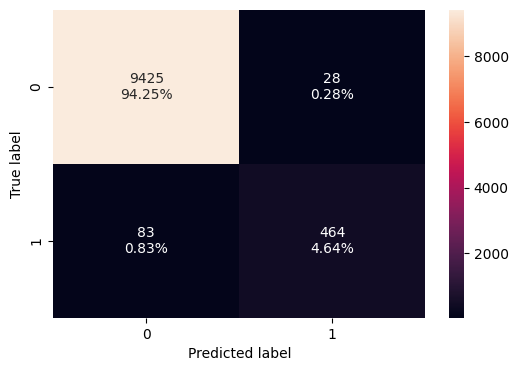

In [148]:
#Confusion matrix on the test set
confusion_matrix_sklearn(tuned_xgb1, X_test, y_test)

Observations:

* Final model has a accuracy of 0.99 on test data

* Final model has a recall score of 0.87 on test data

* Final model has both the precision and F1 score of 0.86 on test data

* Final model performs quite well with unseen test data

* Final model generalizes quite well with unseen test data

#Feature Importance of Final Model


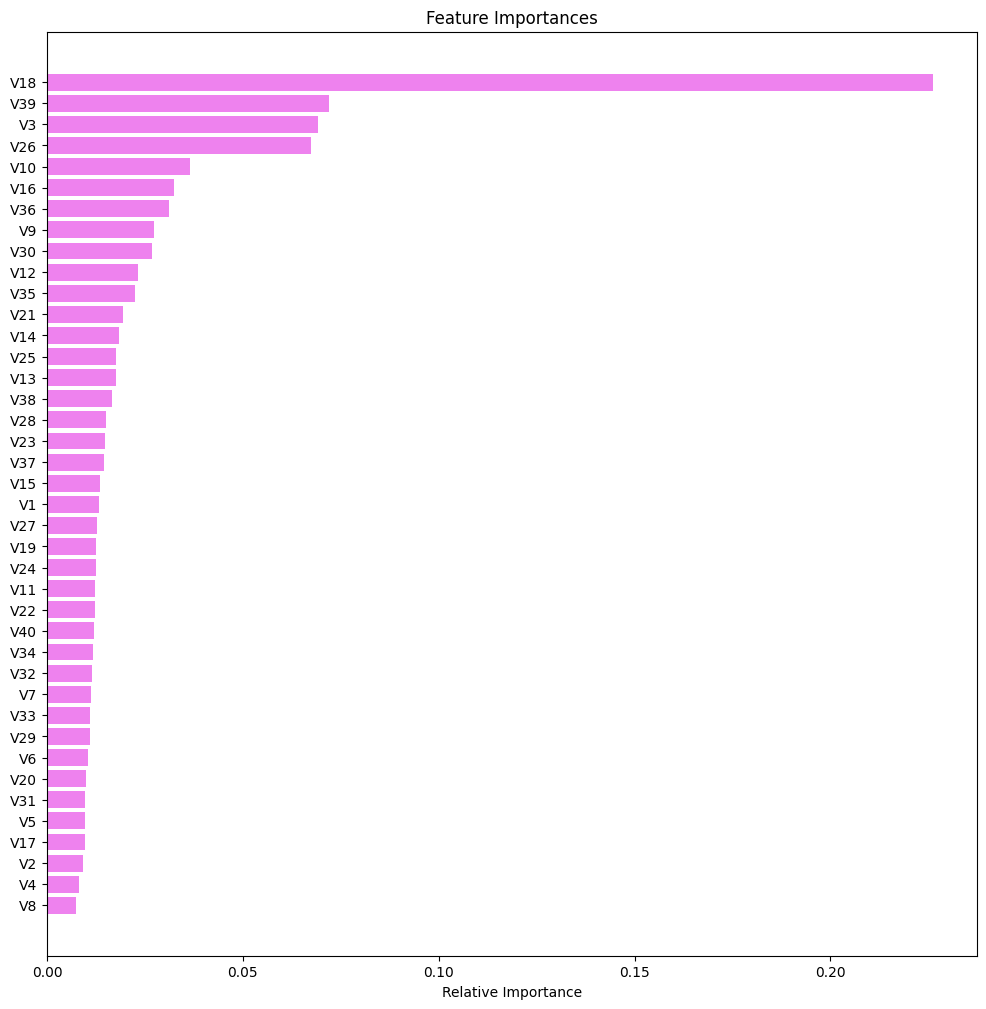

In [149]:
feature_names = X.columns
importances = tuned_xgb1.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

Observations:

* Final model indicates that sensor V18 is one of the most critical sensors in accurately predicting machine failure
* This sensor has a relative importance of nearly 20% almost 3X more than the next most important sensor V36 in predicting machine failure
* Next top 3 sensors include V36 , V26 and V39 in decreasing order of importance

#Pipelines to build the final model


In [150]:
# Build a pipeline with simple imputer to impute missing values and use the final model for production
Model = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        (
            "XGB_Tuned",
            XGBClassifier(random_state=1,
                          subsample = 0.9,
                          scale_pos_weight = 10,
                          n_estimators = 150,
                          learning_rate = 0.2,
                          gamma = 3
            ),
        ),
    ]
)

In [151]:
# Separating target variable and other variables
X1 = df.drop(columns="Target")
Y1 = df["Target"]

# Since we already have a separate test set, we don't need to divide data into train and test

X_test1 = df_test.drop(["Target"], axis=1)
y_test1 = df_test["Target"]

In [152]:
# Treating missing values in train set
imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)

# Treating missing values in the test set
X2 = imputer.transform(X_test1)

In [153]:
# Fit the productionized model
Model.fit(X1, Y1)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('XGB_Tuned',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=150, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

In [156]:
# Make predictions on the test data using the productionized model
Model.predict(X2)

array([0, 0, 0, ..., 0, 0, 0])

# Conclusions


* A number of classification type machine learning models were utilized in order to accurately predict generator failure of wind turbines using sensor data

* The key objective was to identify generator failure or breaking before it happened in order to reduce maintenance cost given that the replacement cost (for predicting no failure when it actually fails) is 2X the repair cost+inspection cost (for correctly predicting failure)

* 7 different type of classifier models were utilized namely the following:

  * Logistic Regression
  * Decision Tree
  * Bagging Classifier
  * Random Forest Classifier
  * Gradient Boosting Classifier
  * Ada Boosting Classifier
  * XGBoost Classifier
*  Dataset is highly imbalanced with the minority class predicting generator failure making up only 5% of the observations

* Oversampling and undersampling techniques were employed on the original data to improve the predictive power of the model on the minority class - Class 1 denoting Failure

* Hyperparameter tuning was performed on some of these models with the objective of improving performance as well as reducing overfitting and underfitting when applicable

* Two top models were identified based on performance particularly recall score as well as model generalization on unseen data. These are

  * (1) Tuned Random Forest Classifier using Oversampled data
  * (2) Tuned XGBoost Classifier using original data
* Of these 2 models, XGBoost Classifier using original data was chosen as the final model
* Recall score on the final model was 87% on the unseen test data.

* Model accuracy for the final model was 99% and precision and F1 score were 86% each

* Final model indictated sensor V18 to be the most important sensor in terms of predicting generator failure. Other 3 important sensors in decreasing order of importance are V36, V26 and V39

# Business Insights


* Sensor V18 (followed by sensors V36, V26 and V39 to a lesser extent) are critical in terms of indicating pending generator failure

  * Renewind is recommended to pay very close attention to data coming from sensor V18 (and maybe potentially sensors V36, V26 and V39 as well). These sensors are somewhat more predictive of a generator failure relative to other sensors
  * Any indication of a looming generator failure from the data should be used to send out a technician for inspection and/or repair (if needed).
* ML models were built using recall score as the key metric for predicting generator failure. Instead, an alternative approach could be used where the total service cost is used as the metric with the objective being to lower this cost

* Total service cost based on the different ML models could be computed using the confusion matrix
* Total service cost could be computed by adding the following:
  * Cost of accurately predicting generator failure [True Positive (TP)] (Inspection cost + Repair cost)
  * Cost of accurately predicting no generator failure [True Negative (TN)] (No cost)
  * Cost of incorrectly predicting generator failure [False Positive (FP)] (Inspection cost only and no repair cost)
  * Cost of incorrectly predicting no generator failure when actual failure is happening [False Negative (FN)] ( Replacement cost)
* Models with the lowest total service cost could be chosen as opposed to the model with best recall
* This approach may help ReneWind incur lower costs in the maintenance of the generator in the long-run
* Renewind could be consulted on how critical it is to further improve recall score and make a predictive model that generalizes even better with unseen data. Depending on their decision, an ML model could be built with increased time complexity using the more time intensive GridSearchCV instead of RandomizedSearchCV as well as utilize a wider range of hyperparameters to see if model performance and generalizability could be further enhanced.

* We could also seek more data from existing/additional sensors (if possible) so that a more generalizable model with even better performance could be built trained on a larger dataset and tested on a larger unseen data